# Gaussian migration scheme

Currently, to determine radial and vertical migration throughout the disk, VICE assigns an analog star particle from the h277 simulation to each of the stellar populations in the chemical evolution simulation. However, in regions where h277 has a very low stellar density (such as in the outer galaxy at early times), the same analog particle can be assigned to many VICE populations, leading to "clumping" in the VICE chemical abundance output. In this notebook I explore an alternative migration scheme in which the radial and vertical migration distances ($\Delta R$ and $z_{\rm{final}}$, respectively) are drawn from a probability distribution function which is based on the distributions in h277 as a function of time and formation radius.

In [156]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import ScalarMappable
from scipy.stats import norm
from scipy.optimize import curve_fit
from vice.toolkit.hydrodisk import hydrodiskstars
sys.path.append(os.path.abspath('../src/scripts'))
from _globals import ZONE_WIDTH, END_TIME
from utils import get_color_list, box_smooth

In [2]:
# Plot settings
plt.rcParams.update({
    'xtick.direction': 'in',
    'xtick.top': True,
    'ytick.direction': 'in',
    'ytick.right': True,
    'figure.dpi': 140,
    'figure.figsize': (5, 3),
})

Import the full h277 data.

In [3]:
radial_bins = np.arange(0, 20.1, ZONE_WIDTH)
h277 = hydrodiskstars(radial_bins, N=3102519)
# Select disk stars only
h277.decomp_filter([1, 2])

Convert to pandas DataFrame and add some useful columns.

In [4]:
data = pd.DataFrame(dict(h277.analog_data))
data.set_index('id', inplace=True)
data['age'] = END_TIME - data['tform']
# limit to stars formed before end of simulation (13.2 Gyr)
data = data[data['age'] >= 0].copy()
data['dr'] = data['rfinal'] - data['rform']
data['dz'] = data['zfinal'].abs() - data['zform'].abs()
data

tform    rform   rfinal   zform  zfinal      vrad      vphi  \
id                                                                        
26924539   0.0041   2.6272   2.0804  0.0594  0.3230  120.2195  233.0608   
26925904   0.0392   2.5430   4.0576  0.0299  2.3774   20.7761  185.2419   
26927333   0.0686   1.9708   4.1744  0.0650  0.3139   69.9736  141.0999   
26927480   0.0702   2.6203   3.1829 -0.0153  2.5367  -87.8513   94.7288   
26927646   0.0727   2.6671   3.1970  0.0186 -1.8902  -74.3674  154.2642   
...           ...      ...      ...     ...     ...       ...       ...   
35026868  13.1995   0.9124   0.9124 -0.0367 -0.0367   53.1782  206.0127   
35026886  13.1995  10.7958  10.7958 -0.0613 -0.0613   27.6196  202.2368   
35026893  13.1995  13.6706  13.6706 -0.1850 -0.1850  -11.0150  183.4338   
35026911  13.1995   6.7628   6.7628 -0.0704 -0.0704   11.9025  215.9159   
35026947  13.1995   9.8130   9.8130 -0.0774 -0.0774   -9.6867  205.2564   

                vz  decomp      age      dr      dz  
id                                                   
26924539   49.1263       1  13.1959 -0.5468  0.2636  
26925904  111.5484       2  13.1608  1.5146  2.3475  
26927333 -184.4511       2  13.1314  2.2036  0.2489  
26927480   20.4146       2  13.1298  0.5626  2.5214  
26927646  -17.6464       2  13.1273  0.5299  1.8716  
...            ...     ...      ...     ...     ...  
35026868   11.6861       1   0.0005  0.0000  0.0000  
35026886    3.0049       1   0.0005  0.0000  0.0000  
35026893    4.5975       1   0.0005  0.0000  0.0000  
35026911    6.8991       1   0.0005  0.0000  0.0000  
35026947  -10.9859       1   0.0005  0.0000  0.0000  

[1747629 rows x 12 columns]

## Radial Migration

First, plot the distribution of $\Delta R = R_{\rm{final}} - R_{\rm{form}}$ in bins of varying formation radius $R_{\rm{form}}$ and age $\tau$. I've applied boxcar smoothing with a width of 0.5 kpc for visual clarity.

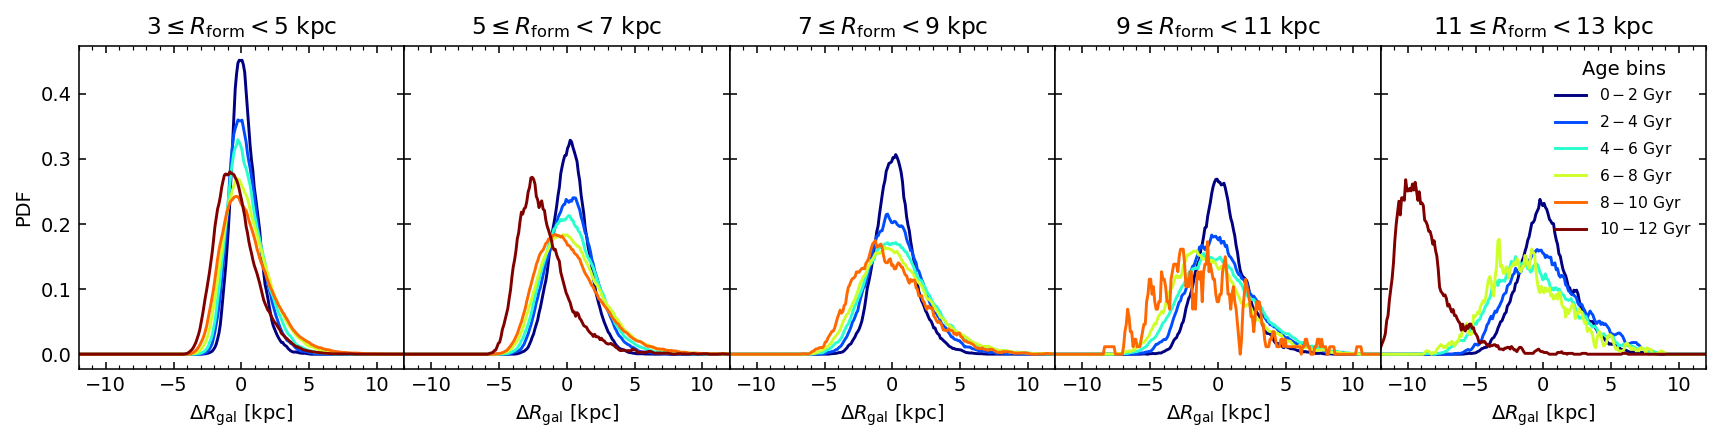

In [35]:
rform_bins = np.arange(3, 15, 2, dtype='float')
age_bins = np.arange(0, 14, 2, dtype='float')
dr_bins = np.arange(-20, 20.1, 0.1)

# pick discrete colors
cmap = plt.get_cmap('jet')
colors = get_color_list(cmap, age_bins)

fig, axs = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.)

for i, ax in enumerate(axs):
    rform_lim = tuple(rform_bins[i:i+2])
    ax.set_title(r'$%d\leq R_{\rm{form}} < %d$ kpc' % rform_lim)
    ax.set_xlabel(r'$\Delta R_{\rm{gal}}$ [kpc]')
    for j, color in enumerate(colors):
        age_lim = tuple(age_bins[j:j+2])
        # bin h277 data by formation radius and age
        subset = data[(data['rform'] >= rform_lim[0]) &
                      (data['rform'] <  rform_lim[1]) &
                      (data['age']   >= age_lim[0]) &
                      (data['age']   <  age_lim[1]) &
                      # remove youngest stars which haven't migrated at all
                      (data['dr']    != 0)]
        # limit to bins with a meaningful number of stars
        if subset.shape[0] > 100:
            hist, _ = np.histogram(subset['dr'], dr_bins, density=True)
            # apply boxcar smoothing with a width of 0.5 kpc
            hist_smooth = box_smooth(hist, dr_bins, 0.5)
            bin_centers = (dr_bins[:-1] + dr_bins[1:]) / 2
            if i == 0:
                label = r'$%d - %d$ Gyr' % age_lim
            else:
                label = None
            ax.plot(bin_centers, hist_smooth, c=color, ls='-', label=label)

axs[0].xaxis.set_major_locator(MultipleLocator(5))
axs[0].xaxis.set_minor_locator(MultipleLocator(1))
axs[0].set_xlim((-12, 12))
axs[0].set_ylabel('PDF')
fig.legend(title='Age bins', loc='upper right', fontsize=8,
           bbox_to_anchor=(0.9, 0.88), frameon=False)
plt.show()

Most of the distributions appear to be approximately Gaussian in shape and centered on $\Delta R=0$. The innermost annulus (3 - 5 kpc) appears to have slightly skewed distributions, which could be explained by effects from the bar and the fact that $\Delta R$ can't be larger than $R_{\rm{form}}$. 

Some of the older populations also appear skewed at larger radii. One possible explanation for this could be star formation triggered by an infalling dwarf galaxy, which would produce a large population of stars migrating inward from the start. This is almost certainly the case in the oldest age and outermost radial bin, which has far too many stars for its location and time, all of which experience huge inward radial migrations. If I'm going to fit these distributions with a Gaussian centered at 0, I'll need to filter out some of the regions where this is a big effect.

### Frankel et al. (2018) prescription

[Frankel et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...865...96F/abstract) present a prescription for radial migration as a function of age:

$$ \sigma_{\Delta R} = \sigma_{\rm{RM8}} \sqrt{\tau/8\,\rm{Gyr}} $$

where $\sigma_{\Delta R}$ is the scale of the Gaussian distribution of $\Delta R$. They find a global radial orbit migration length scale of $\sigma_\rm{RM8} = 3.6\pm0.1$ kpc.

In [6]:
def frankel2018_migr_scale(age, efficiency=3.6):
    r"""
    Standard deviation of the Gaussian migration scheme from Frankel et al. (2018).
    
    The probability of a star born at a given time migrating by a certain distance 
    by now is a Gaussian centered on 0 with a scale length given by this function.
    
    Parameters
    ----------
    age : float
        Age of star particle in Gyr.
    efficiency : float, optional
        Global radial orbit migration efficiency parameter $\sigma_{\rm{RM8}}$ in
        Frankel et al. (2018), measured in kpc. The default is 3.6.
    
    Returns
    -------
    float
        Radial migration scale $\sigma_\rm{RM}$ in kpc.
    """
    return efficiency * (age / 8) ** 0.5

This prescription doesn't take $R_\rm{form}$ into account, which we've seen is an important factor for determining $\Delta R$. First I compare it to distributions of $\Delta R$ from h277 binned by age only. I limit to the Solar annulus to avoid effects due to the changing size of the Galaxy with time.

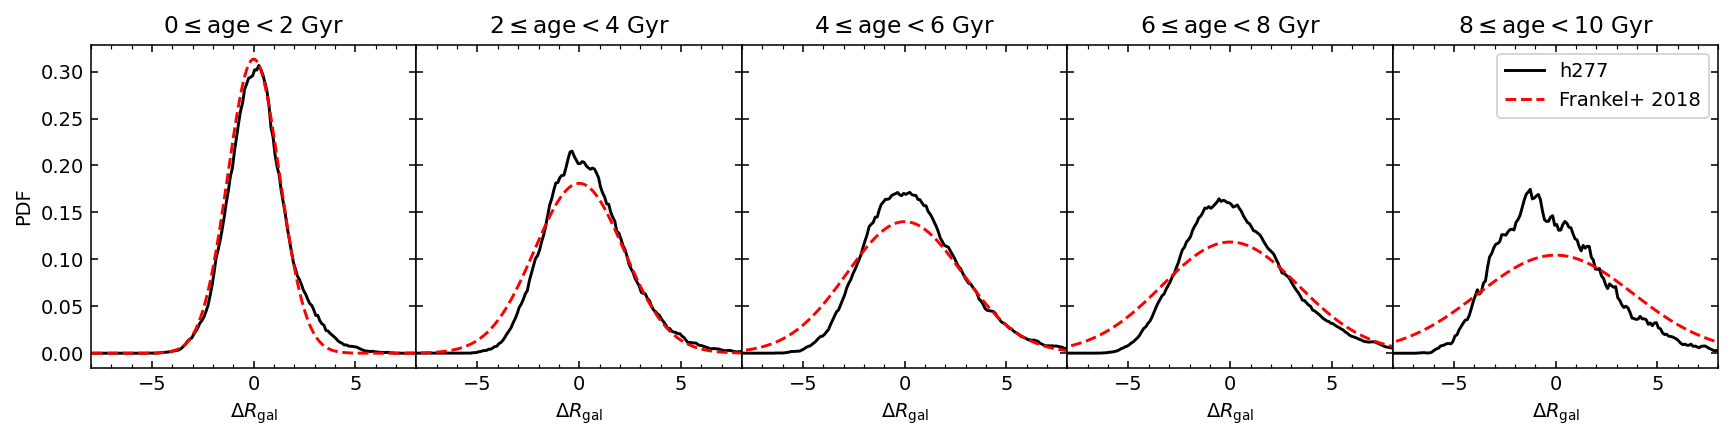

In [7]:
age_bins = np.arange(0, 12, 2, dtype='float')
dr_bins = np.arange(-20, 20.1, 0.1)

fig, axs = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.)

for i, ax in enumerate(axs):
    age_lim = tuple(age_bins[i:i+2])
    subset = data[(data['rform'] >= 7) &
                  (data['rform'] <  9) &
                  (data['age']   >= age_lim[0]) &
                  (data['age']   <  age_lim[1]) &
                  (data['dr']    != 0.)]
    hist, _ = np.histogram(subset['dr'], dr_bins, density=True)
    hist_smooth = box_smooth(hist, dr_bins, 0.5)
    bin_centers = (dr_bins[:-1] + dr_bins[1:]) / 2
    ax.plot(bin_centers, hist_smooth, c='k', ls='-', label='h277')
    # model gaussian
    mean_age = (age_lim[0] + age_lim[1]) / 2
    ax.plot(bin_centers, norm.pdf(bin_centers, 0, frankel2018_migr_scale(mean_age)), 
            c='r', ls='--', label='Frankel+ 2018')
    ax.set_title(r'$%d\leq \rm{age} < %d$ Gyr' % age_lim)
    ax.set_xlabel(r'$\Delta R_{\rm{gal}}$')

axs[0].set_ylabel('PDF')
axs[0].set_xlim((-8, 8))
axs[0].xaxis.set_minor_locator(MultipleLocator(1))
axs[-1].legend()

plt.show()

The fit is ok, but not great. It does well to reproduce the distribution of the youngest stars, but grows too broad for the older populations.  The $\sqrt{\tau}$ dependence in Frankel et al. (2018) assumes the diffusion approximation holds for the Milky Way. [Okalidis et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.514.5085O) find in the Auriga simulations that "stars migrate approximately as a diffusion process only in the outer parts of the discs and for particular galaxies that have a weak bar. Stronly barred galaxies in our sample show larger stellar migration but its timestep evolution is slower-than-diffusion." This seems to be in  line with the above plot.

The full plot below again demonstrates that the Frankel et al. (2018) prescription fails to capture the dependence of $\Delta R$ on $R_\rm{form}$ as well as overestimating its dependence on age.

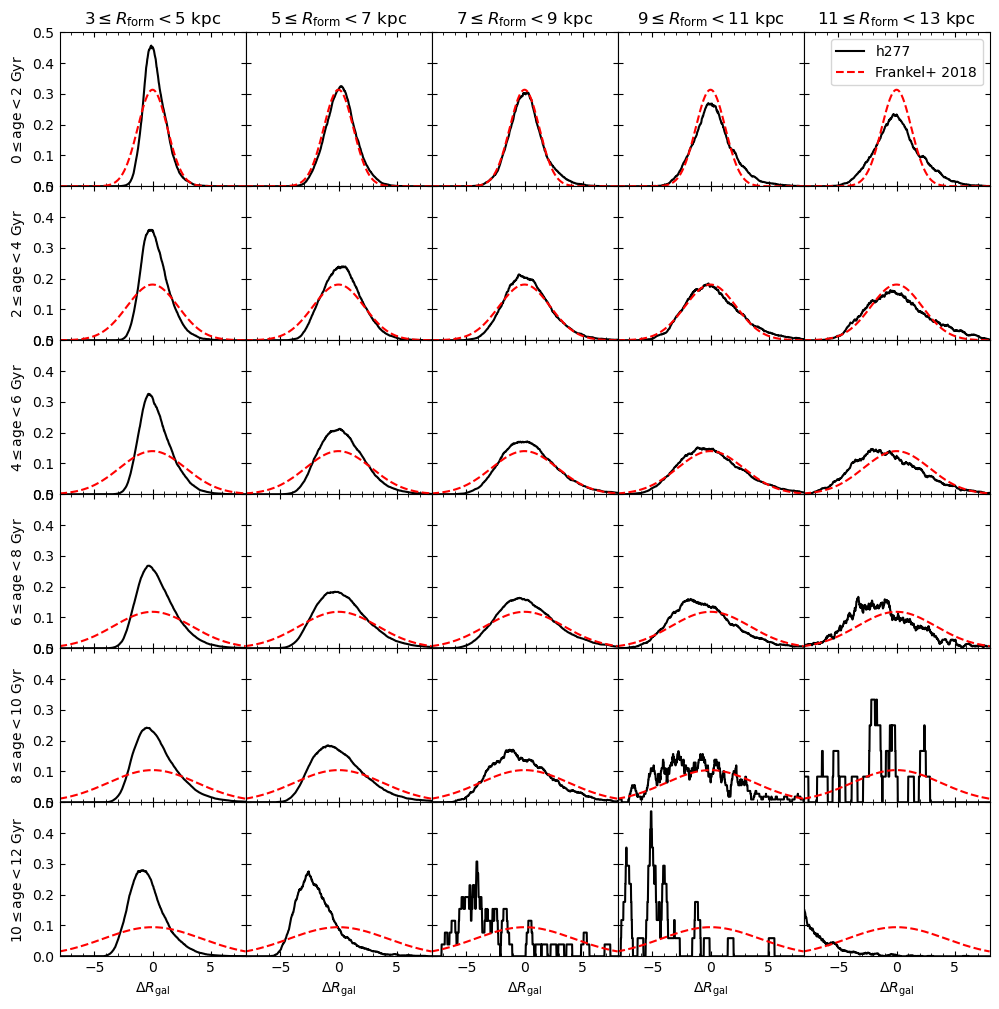

In [8]:
rform_bins = np.arange(3, 15, 2, dtype='float')
age_bins = np.arange(0, 14, 2, dtype='float')
dr_bins = np.arange(-20, 20.1, 0.02)

fig, axs = plt.subplots(6, 5, figsize=(12, 12), sharex=True, sharey=True, dpi=100)
plt.subplots_adjust(wspace=0., hspace=0.)

for i, row in enumerate(axs):
    age_lim = tuple(age_bins[i:i+2])
    for j, ax in enumerate(row):
        rform_lim = tuple(rform_bins[j:j+2])
        subset = data[(data['rform'] >= rform_lim[0]) &
                      (data['rform'] <  rform_lim[1]) &
                      (data['age'] >= age_lim[0]) &
                      (data['age'] <  age_lim[1]) & 
                      (data['dr'] != 0.)             # cut stars w/ exactly 0 migration
                     ]
        # h277 distribution
        hist, _ = np.histogram(subset['dr'], dr_bins, density=True)
        hist_smooth = box_smooth(hist, dr_bins, 0.5)
        bin_centers = (dr_bins[:-1] + dr_bins[1:]) / 2
        ax.plot(bin_centers, hist_smooth, c='k', ls='-', label='h277')
        # model gaussian
        mean_age = (age_lim[0] + age_lim[1]) / 2
        ax.plot(bin_centers, norm.pdf(bin_centers, 0, frankel2018_migr_scale(mean_age)), 
                c='r', ls='--', label='Frankel+ 2018')
        if i == 0:
            ax.set_title(r'$%d\leq R_{\rm{form}} < %d$ kpc' % rform_lim)
        if j == 0:
            ax.set_ylabel(r'$%d\leq \rm{age} < %d$ Gyr' % age_lim)

for ax in axs[-1,:]:
    ax.set_xlabel(r'$\Delta R_{\rm{gal}}$')
axs[0,-1].legend()
axs[0,0].set_xlim((-8, 8))
axs[0,0].set_ylim((0, 0.5))
axs[0,0].xaxis.set_minor_locator(MultipleLocator(1))

plt.show()

### Gaussian fits

The plot above shows that the h277 distributions remain reasonably well-centered in the Solar annulus for populations younger thatn 10 Gyr, and for all radial bins in the youngest populations. Here I fit a Gaussian centered at 0 to the distributions in the Solar annulus binned in age, and again for the distributions in the 0 - 2 Gyr age bin across the disk. I choose to center my age dependence at 1 Gyr rather than 8 Gyr as in Frankel et al. (2018) because the distributions are much better sampled across the Galactic disk at that time.

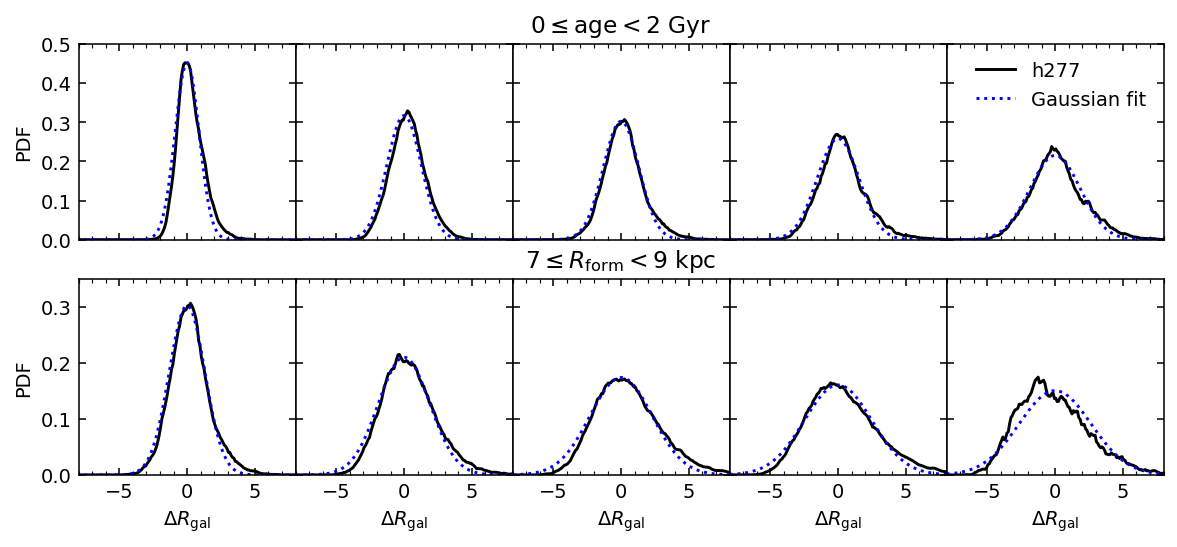

In [9]:
# custom centered normal distribution
norm_centered = lambda x, sig: norm.pdf(x, 0., sig)

age_bin_width = 2
age_bins = np.arange(0, 12, age_bin_width, dtype='float')
age_arr = (age_bins[:-1] + age_bins[1:]) / 2
rform_bin_width = 2
rform_bins = np.arange(3, 15, rform_bin_width, dtype='float')
rform_arr = (rform_bins[:-1] + rform_bins[1:]) / 2
dr_bins = np.arange(-20, 20.1, 0.1)

# plot demonstrating Gaussian fits
fig, axs = plt.subplots(2, 5, figsize=(10, 4), sharex=True, sharey='row')
plt.subplots_adjust(wspace=0., hspace=0.2)

# fixed age, varying rform
fixed_age_lim = (0, 2)
axs[0,2].set_title(r'$%d \leq \rm{age} < %d$ Gyr' % fixed_age_lim)
rform_params = np.zeros(rform_arr.shape)
rform_errors = np.zeros(rform_arr.shape)
for i in range(rform_bins.shape[0] - 1):
    rform_lim = tuple(rform_bins[i:i+2])
    subset = data[(data['rform'] >= rform_lim[0]) &
                  (data['rform'] <  rform_lim[1]) &
                  (data['age']   >= fixed_age_lim[0]) &
                  (data['age']   <  fixed_age_lim[1]) & 
                  (data['dr']    != 0.)]
    # h277 distribution
    hist, _ = np.histogram(subset['dr'], dr_bins, density=True)
    hist_smooth = box_smooth(hist, dr_bins, 0.5)
    bin_centers = (dr_bins[:-1] + dr_bins[1:]) / 2
    axs[0,i].plot(bin_centers, hist_smooth, 'k-', label='h277')
    # model gaussian
    popt, pcov = curve_fit(norm_centered, bin_centers, hist, p0=(3.6))
    axs[0,i].plot(bin_centers, norm_centered(bin_centers, *popt), 'b:',
                  label='Gaussian fit')
    # save params
    rform_params[i] = popt[0]
    rform_errors[i] = np.sqrt(np.diag(pcov))[0]

# fixed rform, varying age
fixed_rform_lim = (7, 9)
axs[1,2].set_title(r'$%d \leq R_{\rm{form}} < %d$ kpc' % fixed_rform_lim)
age_params = np.zeros(age_arr.shape)
age_errors = np.zeros(age_arr.shape)
for i in range(age_bins.shape[0] - 1):
    age_lim = tuple(age_bins[i:i+2])
    subset = data[(data['rform'] >= fixed_rform_lim[0]) &
                  (data['rform'] <  fixed_rform_lim[1]) &
                  (data['age']   >= age_lim[0]) &
                  (data['age']   <  age_lim[1]) & 
                  (data['dr']    != 0.)]
    hist, _ = np.histogram(subset['dr'], dr_bins, density=True)
    hist_smooth = box_smooth(hist, dr_bins, 0.5)
    bin_centers = (dr_bins[:-1] + dr_bins[1:]) / 2
    axs[1,i].plot(bin_centers, hist_smooth, 'k-', label='h277')
    # model gaussian
    popt, pcov = curve_fit(norm_centered, bin_centers, hist, p0=(3.6))
    axs[1,i].plot(bin_centers, norm_centered(bin_centers, *popt), 'b:',
                  label='Gaussian fit')
    age_params[i] = popt[0]
    age_errors[i] = np.sqrt(np.diag(pcov))[0]

for ax in axs[1,:]:
    ax.set_xlabel(r'$\Delta R_{\rm{gal}}$')
axs[0,0].set_xlim((-8, 8))
axs[0,0].xaxis.set_minor_locator(MultipleLocator(1))
for ax in axs[:,0]:
    ax.set_ylabel('PDF')
axs[0,0].set_ylim((0, 0.5))
axs[1,0].set_ylim((0, 0.35))
axs[0,-1].legend(frameon=False)
plt.show()

Next, plot the best-fit parameters as a function of age and $R_\rm{form}$ and fit a power law for each.

In [10]:
def powerlaw(x, coeff, slope):
    """
    An unnormalized power law.
    
    Parameters
    ----------
    x : float or array-like
        Independent variable.
    coeff : float
        Coefficient.
    slope : float
        Power law slope.
        
    Returns
    -------
    float
        Result = coeff * x ** slope.
    """
    return coeff * x ** slope

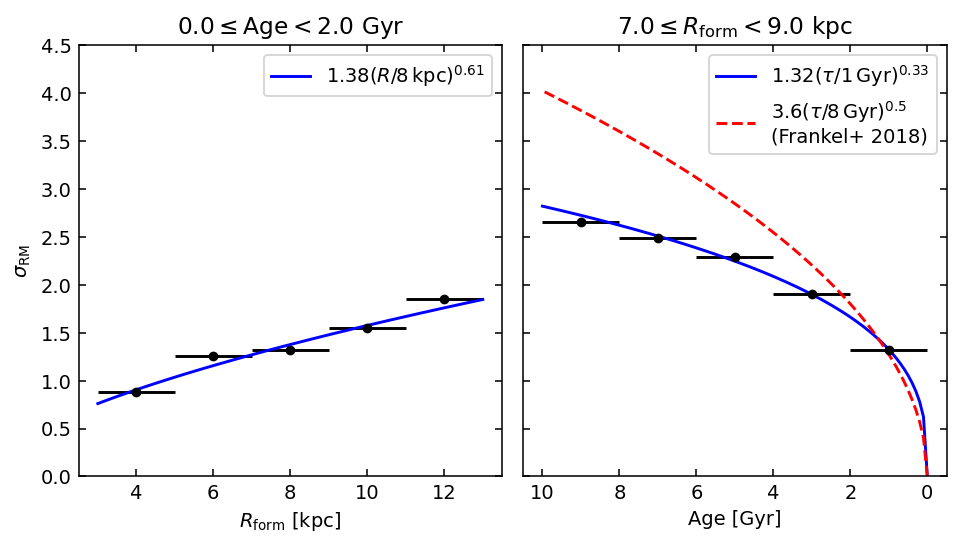

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
plt.subplots_adjust(wspace=0.05)

# fixed age, varying rform
axs[0].errorbar(rform_arr, rform_params, xerr=1, yerr=rform_errors, 
                linestyle='none', c='k', marker='o', markersize=4)
# plaw fit, scaled to 8 kpc
popt, pcov = curve_fit(powerlaw, rform_arr/8, np.array(rform_params), 
                       sigma=rform_errors)
rform_plot_arr = np.arange(3, 13.1, 0.1)
axs[0].plot(rform_plot_arr, powerlaw(rform_plot_arr/8, *popt), 'b-', 
            label=r'$%.02f (R/8\,\rm{kpc})^{%.02f}$' % tuple(popt))
axs[0].set_xlabel(r'$R_{\rm{form}}$ [kpc]')
axs[0].set_ylabel(r'$\sigma_{\rm{RM}}$')
axs[0].set_title(r'$%.1f \leq \rm{Age} < %.1f$ Gyr' % fixed_age_lim)
axs[0].legend()

# fixed rform, varying age
axs[1].errorbar(age_arr, age_params, xerr=1, yerr=age_errors, 
                linestyle='none', c='k', marker='o', markersize=4)
# Plot plaw fit
popt, pcov = curve_fit(powerlaw, age_arr, np.array(age_params), 
                       sigma=age_errors)
age_plot_arr = np.arange(0, 10.1, 0.1)
axs[1].plot(age_plot_arr, powerlaw(age_plot_arr, *popt), 'b-', 
            label=r'$%.02f (\tau/1\,\rm{Gyr})^{%.02f}$' % tuple(popt))
# Plot Frankel+ 2018
axs[1].plot(age_plot_arr, frankel2018_migr_scale(age_plot_arr), 'r--', 
            label=r'$3.6 (\tau/8\,\rm{Gyr})^{0.5}$' + '\n(Frankel+ 2018)')
axs[1].set_xlabel('Age [Gyr]')
axs[1].invert_xaxis()
axs[1].xaxis.set_major_locator(MultipleLocator(2))
axs[1].set_title(r'$%.1f \leq R_{\rm{form}} < %.1f$ kpc' % fixed_rform_lim)
axs[1].legend()

axs[0].set_ylim((0, 4.5))

plt.show()

So my equation for the dependence of $\sigma_{\Delta R}$ on age and formation radius is:

$$ \sigma_{\Delta R} = 1.35 (R_\rm{form}/8\,\rm{kpc})^{0.61} (\tau/1\,\rm{Gyr})^{0.33} $$

In [12]:
def migr_scale(age, rform):
    r"""
    A prescription for $\sigma_{\Delta R}$, the scale of the Gaussian distribution of radial migration.
    
    $$ \sigma_{\Delta R} = 1.35 (R_\rm{form}/8\,\rm{kpc})^{0.61} (\tau/1\,\rm{Gyr})^{0.33} $$
    
    Parameters
    ----------
    age : float or array-like
        Age of the stellar population in Gyr.
    rform : float or array-like
        Formation radius of the stellar population in kpc.
    
    Returns
    -------
    float or array-like
    """
    return 1.35 * (age ** 0.33) * (rform / 8) ** 0.61

Let's check how well this works across the whole simulation:

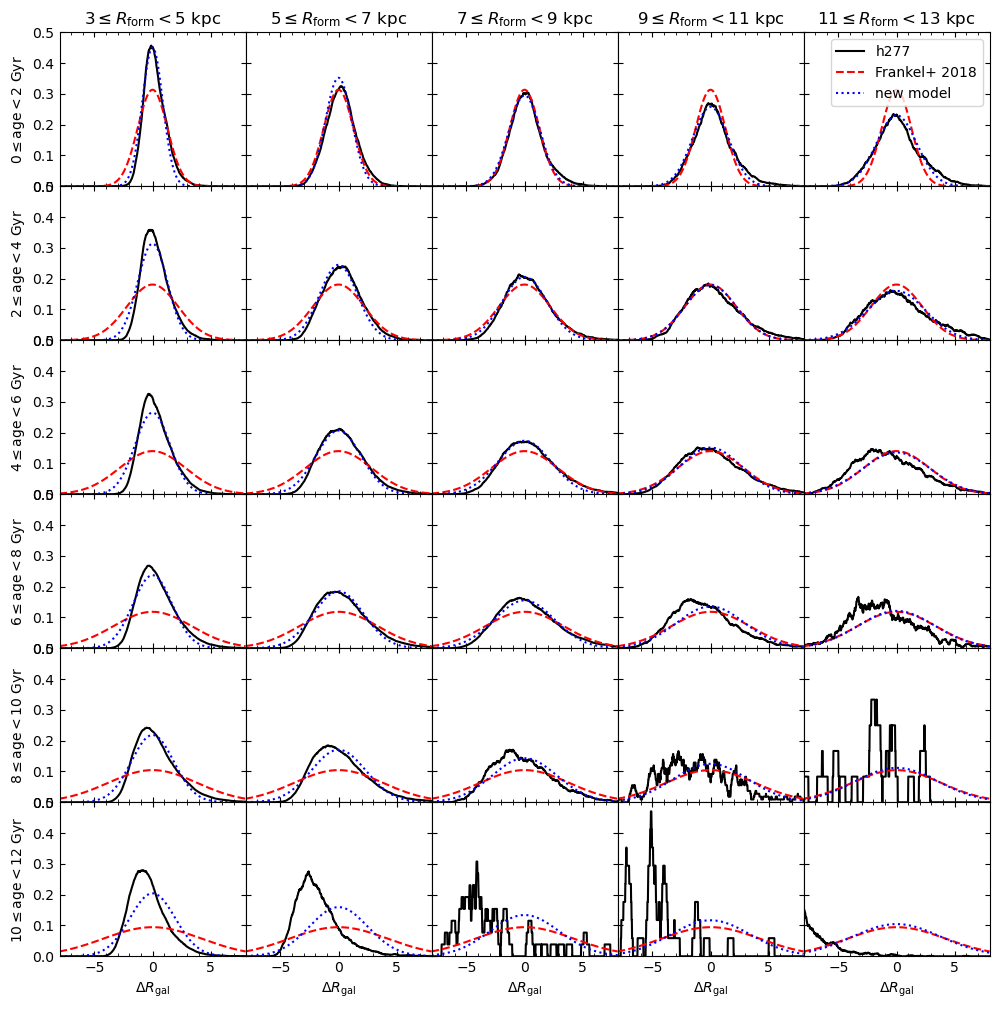

In [13]:
rform_bins = np.arange(3, 15, 2, dtype='float')
age_bins = np.arange(0, 14, 2, dtype='float')
dr_bins = np.arange(-20, 20.1, 0.02)

fig, axs = plt.subplots(6, 5, figsize=(12, 12), sharex=True, sharey=True, dpi=100)
plt.subplots_adjust(wspace=0., hspace=0.)

for i, row in enumerate(axs):
    age_lim = tuple(age_bins[i:i+2])
    for j, ax in enumerate(row):
        rform_lim = tuple(rform_bins[j:j+2])
        subset = data[(data['rform'] >= rform_lim[0]) &
                      (data['rform'] <  rform_lim[1]) &
                      (data['age'] >= age_lim[0]) &
                      (data['age'] <  age_lim[1]) & 
                      (data['dr'] != 0.)             # cut stars w/ exactly 0 migration
                     ]
        hist, _ = np.histogram(subset['dr'], dr_bins, density=True)
        hist_smooth = box_smooth(hist, dr_bins, 0.5)
        bin_centers = (dr_bins[:-1] + dr_bins[1:]) / 2
        ax.plot(bin_centers, hist_smooth, c='k', ls='-', label='h277')
        # model gaussian
        mean_age = (age_lim[0] + age_lim[1]) / 2
        mean_rform = (rform_lim[0] + rform_lim[1]) / 2
        ax.plot(bin_centers, norm.pdf(bin_centers, 0, frankel2018_migr_scale(mean_age)), 
                c='r', ls='--', label='Frankel+ 2018')
        ax.plot(bin_centers, norm.pdf(bin_centers, 0, migr_scale(mean_age, mean_rform)), 
                c='b', ls=':', label='new model')
        if i == 0:
            ax.set_title(r'$%d\leq R_{\rm{form}} < %d$ kpc' % rform_lim)
        if j == 0:
            ax.set_ylabel(r'$%d\leq \rm{age} < %d$ Gyr' % age_lim)

for ax in axs[-1,:]:
    ax.set_xlabel(r'$\Delta R_{\rm{gal}}$')
axs[0,-1].legend()
axs[0,0].set_xlim((-8, 8))
axs[0,0].set_ylim((0, 0.5))
axs[0,0].xaxis.set_minor_locator(MultipleLocator(1))

plt.show()

The new prescription misses some of the skewness at small radii and early times, but overall is a much better fit to the h277 data than the Frankel et al. (2018) prescription.

## Vertical Migration (Final Midplane Distance)

Stellar migration in the disk isn't confined to the radial dimension. Since VICE doesn't model changes in chemical abundances in vertical bins, it essentially treats all stellar populations as forming exactly on the midplane and then migrating to their final distance from the midplane $z_\rm{final}$.

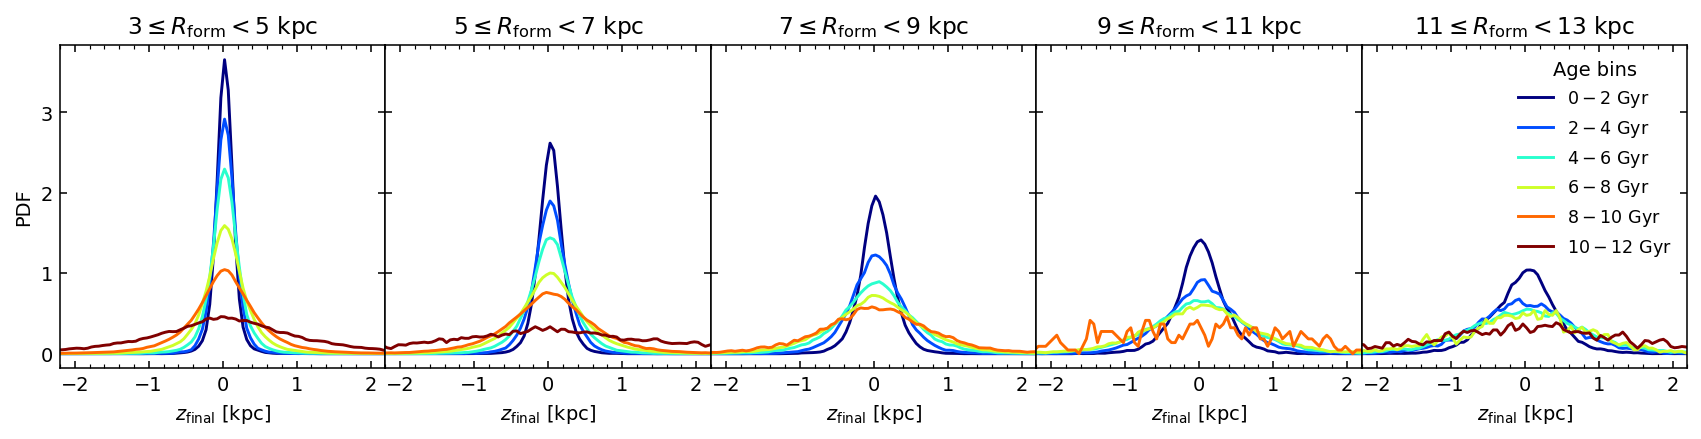

In [71]:
rform_bins = np.arange(3, 15, 2, dtype='float')
age_bins = np.arange(0, 14, 2, dtype='float')

zfinal_bins = np.arange(-5, 5.05, 0.05)

fig, axs = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.)

for i, ax in enumerate(axs):
    rform_lim = tuple(rform_bins[i:i+2])
    ax.set_title(r'$%d\leq R_{\rm{form}} < %d$ kpc' % rform_lim)
    ax.set_xlabel(r'$z_{\rm{final}}$ [kpc]')
    for j, color in enumerate(colors):
        age_lim = tuple(age_bins[j:j+2])
        subset = data[(data['rform'] >= rform_lim[0]) &
                      (data['rform'] <  rform_lim[1]) &
                      (data['age']   >= age_lim[0]) &
                      (data['age']   <  age_lim[1])]
        if subset.shape[0] > 100:
            hist, _ = np.histogram(subset['zfinal'], zfinal_bins, density=True)
            hist_smooth = box_smooth(hist, zfinal_bins, 0.1)
            bin_centers = (zfinal_bins[:-1] + zfinal_bins[1:]) / 2
            if i == 0:
                label = r'$%d - %d$ Gyr' % age_lim
            else:
                label = None
            ax.plot(bin_centers, hist_smooth, c=color, ls='-', label=label)

axs[0].set_ylabel('PDF')
axs[0].set_xlim((-2.2, 2.2))
axs[0].xaxis.set_minor_locator(MultipleLocator(0.2))
fig.legend(title='Age bins', loc='upper right', fontsize=9,
           bbox_to_anchor=(0.9, 0.88), frameon=False)
plt.show()

The distribution of $z_\rm{final}$ isn't a simple Gaussian - possibly the superposition of two Gaussians.

### Thin and Thick Disks

In [22]:
# Thin disk stars
h277_thin = hydrodiskstars(radial_bins, N=3102519)
h277_thin.decomp_filter([1])
data_thin = pd.DataFrame(dict(h277_thin.analog_data))
data_thin.set_index('id', inplace=True)
data_thin['age'] = END_TIME - data_thin['tform']
data_thin = data_thin[data_thin['age'] >= 0].copy()
data_thin['dr'] = data_thin['rfinal'] - data_thin['rform']

# Thick disk stars
h277_thick = hydrodiskstars(radial_bins, N=3102519)
h277_thick.decomp_filter([2])
data_thick = pd.DataFrame(dict(h277_thick.analog_data))
data_thick.set_index('id', inplace=True)
data_thick['age'] = END_TIME - data_thick['tform']
data_thick = data_thick[data_thick['age'] >= 0].copy()
data_thick['dr'] = data_thick['rfinal'] - data_thick['rform']

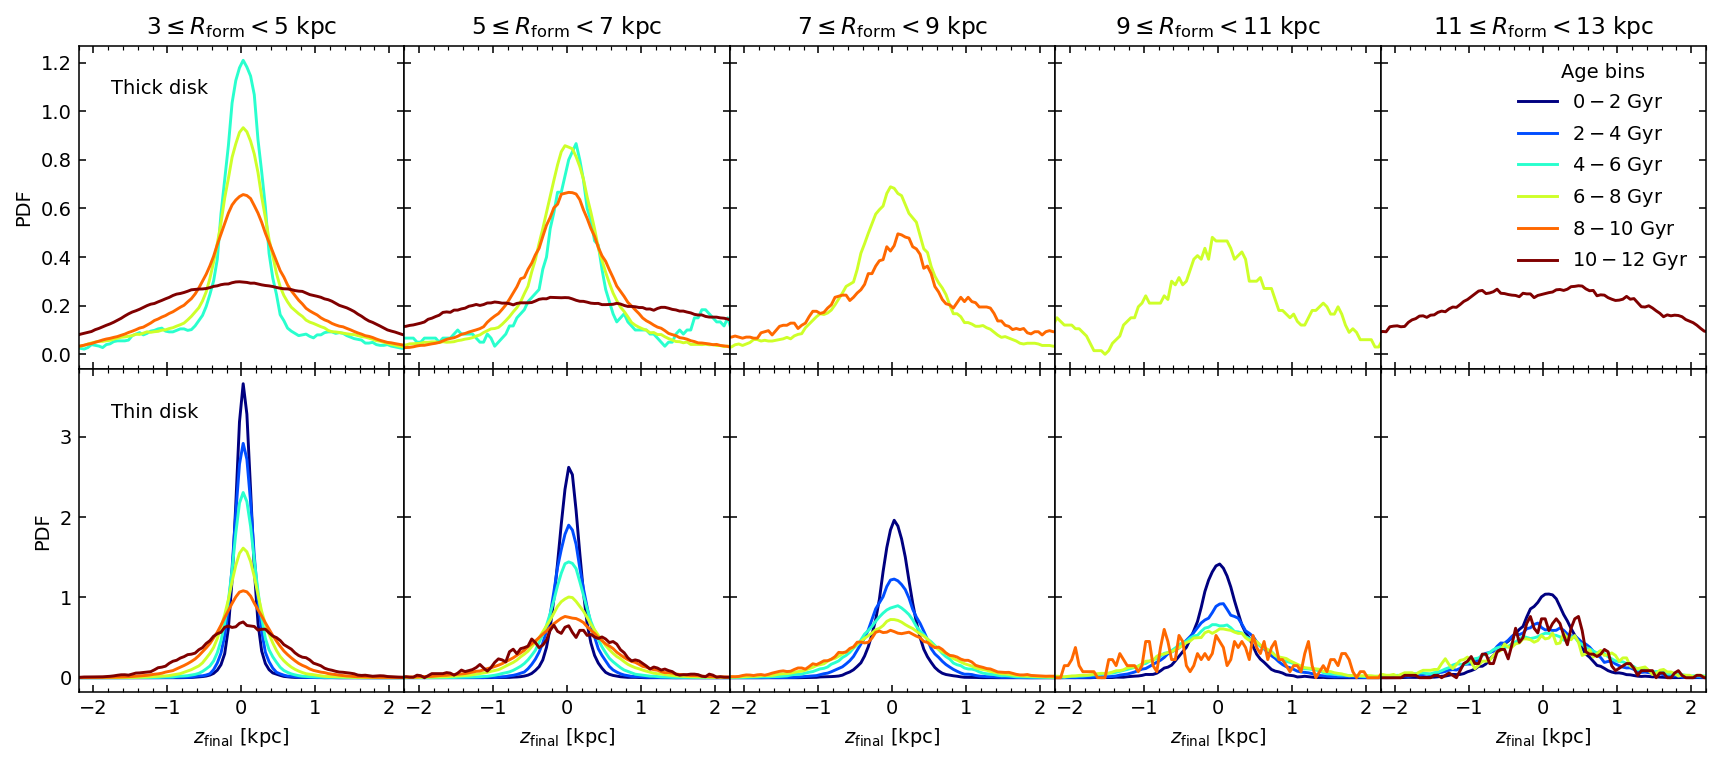

In [72]:
rform_bins = np.arange(3, 15, 2, dtype='float')
age_bins = np.arange(0, 14, 2, dtype='float')

zfinal_bins = np.arange(-5, 5.05, 0.05)

fig, axs = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey='row')
plt.subplots_adjust(wspace=0., hspace=0.)

row_labels = ['Thick disk', 'Thin disk']
smooth_width = [0.5, 0.1]
for n, comp in enumerate([data_thick, data_thin]):
    axs[n,0].text(0.1, 0.85, row_labels[n], transform=axs[n,0].transAxes)
    for i, ax in enumerate(axs[n]):
        rform_lim = tuple(rform_bins[i:i+2])
        if n == 0:
            ax.set_title(r'$%d\leq R_{\rm{form}} < %d$ kpc' % rform_lim)
        if n == 1:
            ax.set_xlabel(r'$z_{\rm{final}}$ [kpc]')
        for j, color in enumerate(colors):
            age_lim = tuple(age_bins[j:j+2])
            subset = comp[(comp['rform'] >= rform_lim[0]) &
                          (comp['rform'] <  rform_lim[1]) &
                          (comp['age']   >= age_lim[0]) &
                          (comp['age']   <  age_lim[1])]
            if subset.shape[0] > 100:
                hist, _ = np.histogram(subset['zfinal'], zfinal_bins, density=True)
                hist_smooth = box_smooth(hist, zfinal_bins, smooth_width[n])
                bin_centers = (zfinal_bins[:-1] + zfinal_bins[1:]) / 2
                if i == 0 and n == 1:
                    label = r'$%d - %d$ Gyr' % age_lim
                else:
                    label = None
                ax.plot(bin_centers, hist_smooth, c=color, ls='-', label=label)

axs[0,0].set_ylabel('PDF')
axs[1,0].set_ylabel('PDF')
axs[0,0].set_xlim((-2.2, 2.2))
axs[0,0].xaxis.set_minor_locator(MultipleLocator(0.2))
fig.legend(title='Age bins', loc='upper right', 
           bbox_to_anchor=(0.9, 0.88), frameon=False)
plt.show()

While the thin and thick disks do have different distribution widths, both are still non-Gaussian.

### Absolute Midplane Distance

The distribution of $|z|$ is expected to be roughly exponential:

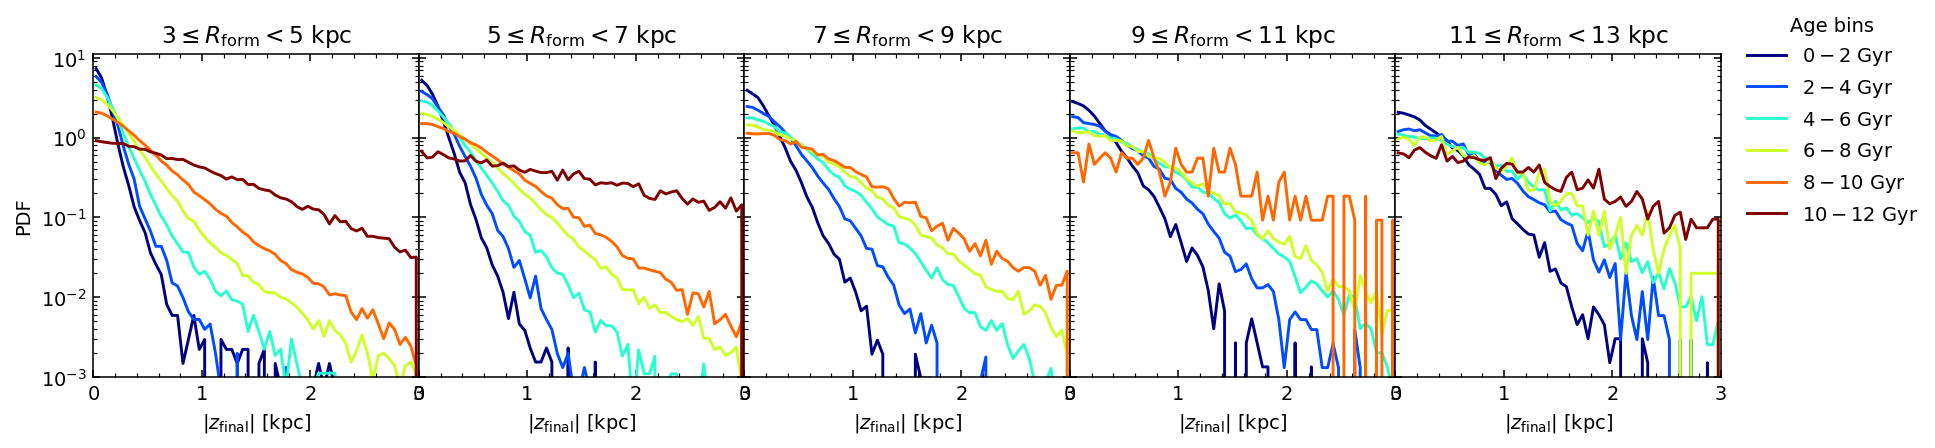

In [108]:
rform_bins = np.arange(3, 15, 2, dtype='float')
age_bins = np.arange(0, 14, 2, dtype='float')
absz_bins = np.arange(0, 5.05, 0.05)

fig, axs = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.)

for i, ax in enumerate(axs):
    rform_lim = tuple(rform_bins[i:i+2])
    ax.set_title(r'$%d\leq R_{\rm{form}} < %d$ kpc' % rform_lim)
    ax.set_xlabel(r'$|z_{\rm{final}}|$ [kpc]')
    for j, color in enumerate(colors):
        age_lim = tuple(age_bins[j:j+2])
        subset = data[(data['rform'] >= rform_lim[0]) &
                      (data['rform'] <  rform_lim[1]) &
                      (data['age'] >= age_lim[0]) &
                      (data['age'] <  age_lim[1])]
        if subset.shape[0] > 100:
            hist, _ = np.histogram(np.abs(subset['zfinal']), absz_bins, density=True)
            bin_centers = (absz_bins[:-1] + absz_bins[1:]) / 2
            if i == 0:
                label = r'$%d - %d$ Gyr' % age_lim
            else:
                label = None
            ax.plot(bin_centers, hist, c=color, ls='-', label=label)

axs[0].set_ylabel('PDF')
axs[0].set_yscale('log')
axs[0].set_xlim((0, 3))
axs[0].xaxis.set_minor_locator(MultipleLocator(0.2))
fig.legend(title='Age bins', loc='upper right', frameon=False)
plt.show()

Here we see that the slope of the exponential distribution varies with $R_\rm{form}$ and age. The distributions are very similar when binned by the _final_ radius $R_\rm{final}$ instead:

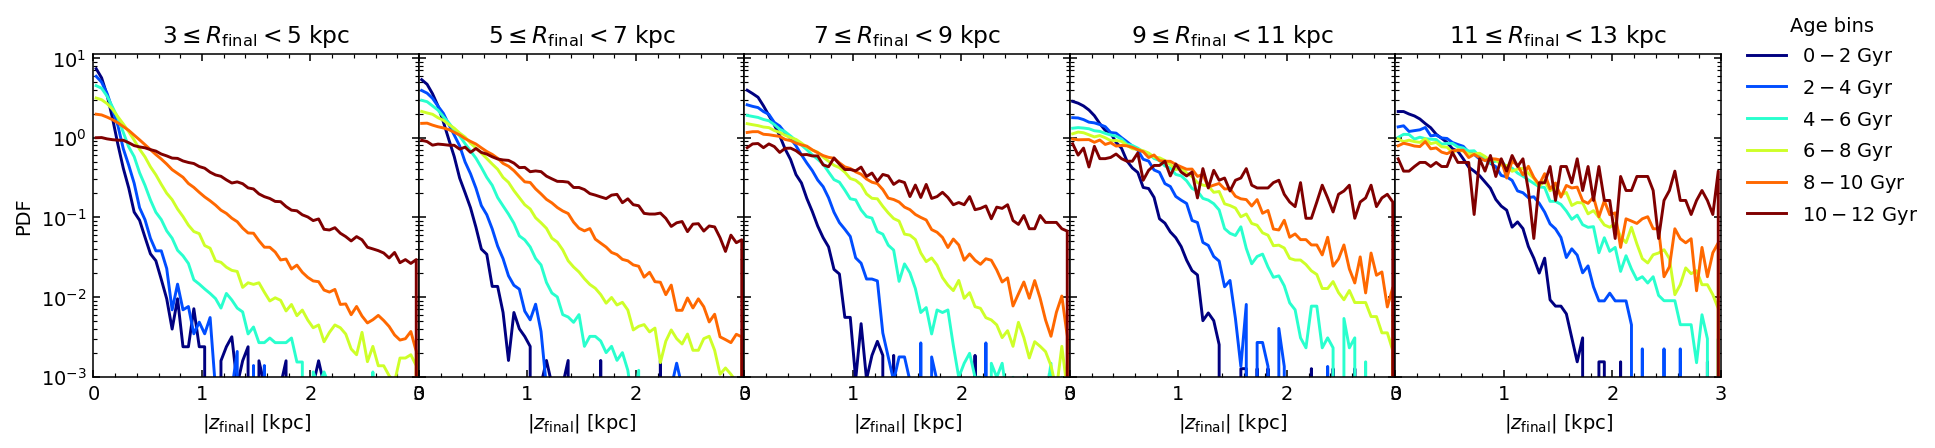

In [109]:
rfinal_bins = np.arange(3, 15, 2, dtype='float')
age_bins = np.arange(0, 14, 2, dtype='float')
absz_bins = np.arange(0, 5.05, 0.05)

fig, axs = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.)

for i, ax in enumerate(axs):
    rfinal_lim = tuple(rfinal_bins[i:i+2])
    ax.set_title(r'$%d\leq R_{\rm{final}} < %d$ kpc' % rfinal_lim)
    ax.set_xlabel(r'$|z_{\rm{final}}|$ [kpc]')
    for j, color in enumerate(colors):
        age_lim = tuple(age_bins[j:j+2])
        subset = data[(data['rfinal'] >= rfinal_lim[0]) &
                      (data['rfinal'] <  rfinal_lim[1]) &
                      (data['age'] >= age_lim[0]) &
                      (data['age'] <  age_lim[1])]
        if subset.shape[0] > 100:
            hist, _ = np.histogram(np.abs(subset['zfinal']), absz_bins, density=True)
            bin_centers = (absz_bins[:-1] + absz_bins[1:]) / 2
            if i == 0:
                label = r'$%d - %d$ Gyr' % age_lim
            else:
                label = None
            ax.plot(bin_centers, hist, c=color, ls='-', label=label)

axs[0].set_ylabel('PDF')
axs[0].set_yscale('log')
axs[0].set_xlim((0, 3))
axs[0].xaxis.set_minor_locator(MultipleLocator(0.2))
fig.legend(title='Age bins', loc='upper right', frameon=False)
plt.show()

When binned by the radial migration distance $\Delta R$, a lot of the age dependence disappears:

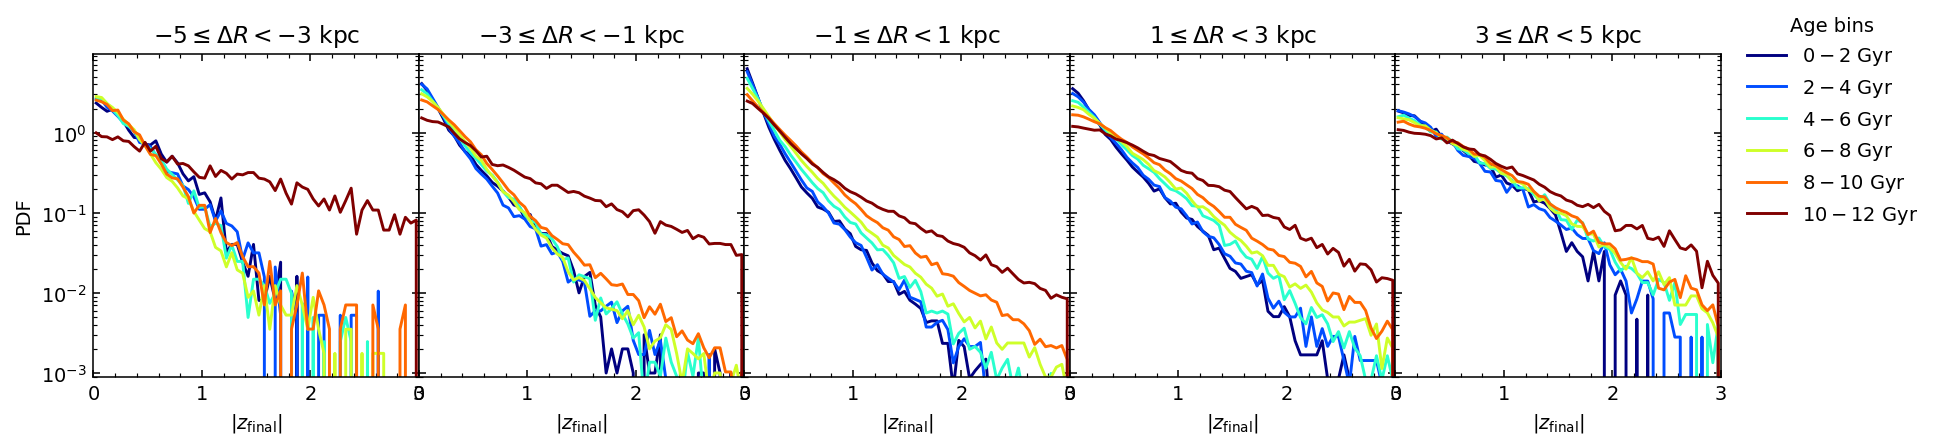

In [110]:
dr_bins = np.arange(-5, 6, 2, dtype='float')
age_bins = np.arange(0, 14, 2, dtype='float')

absz_bins = np.arange(0, 5.05, 0.05)

fig, axs = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.)

for i, ax in enumerate(axs):
    dr_lim = tuple(dr_bins[i:i+2])
    ax.set_title(r'$%d\leq \Delta R < %d$ kpc' % dr_lim)
    ax.set_xlabel(r'$|z_{\rm{final}}|$')
    for j, color in enumerate(colors):
        age_lim = tuple(age_bins[j:j+2])
        subset = data[(data['dr']  >= dr_lim[0]) &
                      (data['dr']  <  dr_lim[1]) &
                      (data['age'] >= age_lim[0]) &
                      (data['age'] <  age_lim[1])]
        if subset.shape[0] > 100:
            hist, _ = np.histogram(np.abs(subset['zfinal']), absz_bins, density=True)
            bin_centers = (absz_bins[:-1] + absz_bins[1:]) / 2
            if i == 0:
                label = r'$%d - %d$ Gyr' % age_lim
            else:
                label = None
            ax.plot(bin_centers, hist, c=color, ls='-', label=label)

axs[0].set_ylabel('PDF')
axs[0].set_yscale('log')
axs[0].set_xlim((0, 3))
axs[0].xaxis.set_minor_locator(MultipleLocator(0.2))
fig.legend(title='Age bins', loc='upper right', frameon=False)
plt.show()

### First model: just $\Delta R$

Motivated by the above plot, the simplest prescription for $|z_\rm{final}|$ would have only a dependence on $\Delta R$, which itself is a function of $R_\rm{form}$ and age. Here I fit an exponential to the distributions of $|z_\rm{final}|$ in bins of $\Delta R$ and then fit a function to describe the exponential scale factor in terms of $\Delta R$.

In [56]:
def exponential(x, coeff, scale):
    return coeff * np.exp(-x/scale)

def normal_exponential(x, scale):
    return exponential(x, 1/scale, scale)

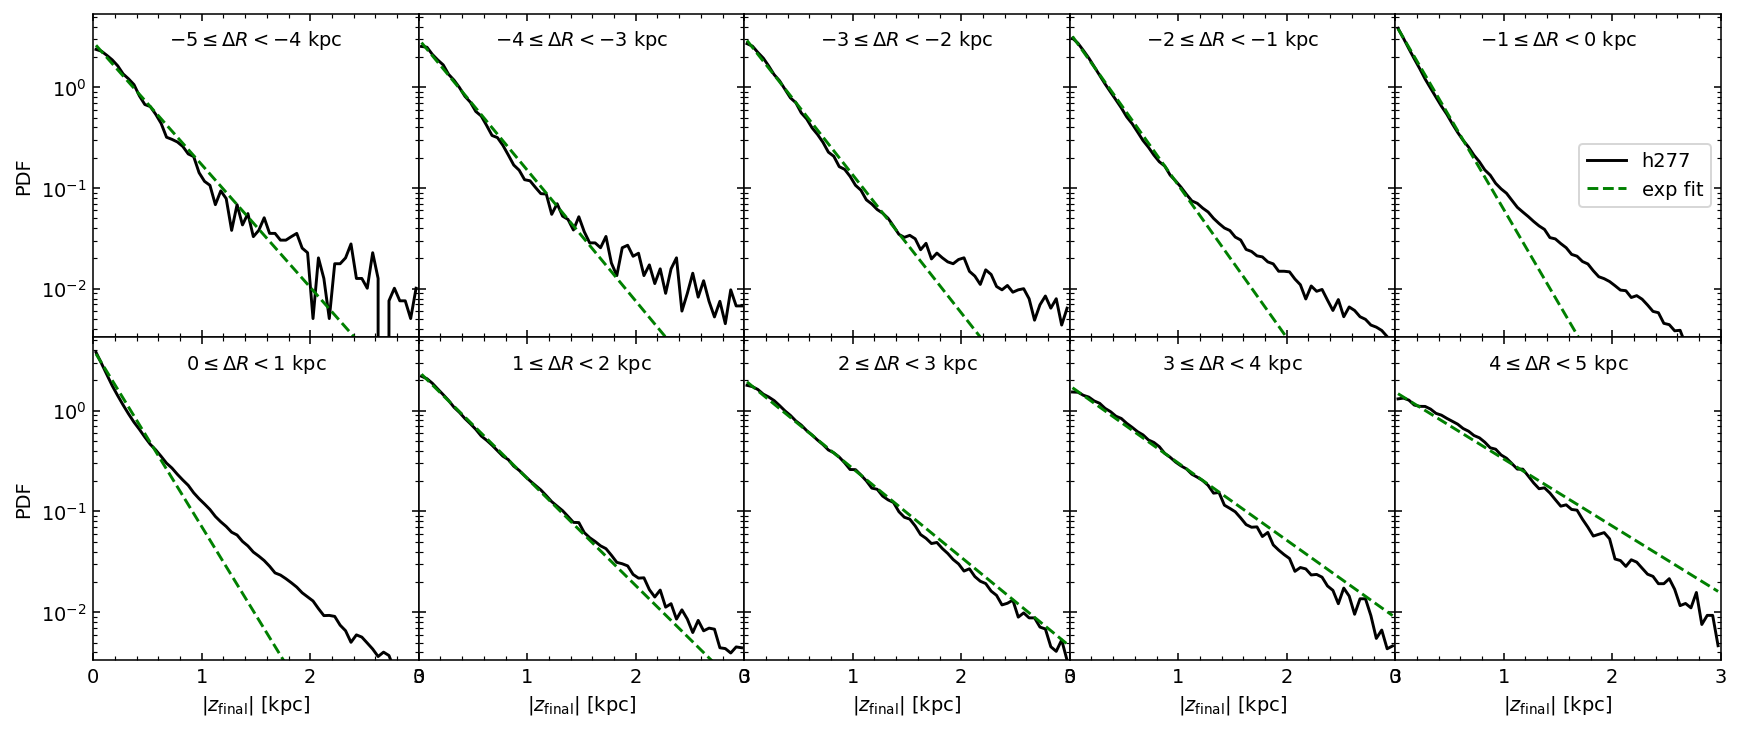

In [57]:
dr_bins = np.arange(-5, 6, 1, dtype='float')
dr_arr = (dr_bins[:-1] + dr_bins[1:]) / 2
absz_bins = np.arange(0., 3.05, 0.05)

fig, axs = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0., hspace=0.)

dr_params = np.zeros(dr_arr.shape)
dr_errors = np.zeros(dr_arr.shape)
for i, ax in enumerate(axs.flatten()):
    dr_lim = tuple(dr_bins[i:i+2])
    ax.text(0.5, 0.9, r'$%d\leq \Delta R < %d$ kpc' % dr_lim,
            ha='center', transform=ax.transAxes)
    if i > dr_bins.shape[0]/2 - 1: 
        ax.set_xlabel(r'$|z_{\rm{final}}|$ [kpc]')
    subset = data[(data['dr'] >= dr_lim[0]) &
                  (data['dr'] <  dr_lim[1])]
    hist, _ = np.histogram(subset['zfinal'].abs(), absz_bins, density=True)
    bin_centers = (absz_bins[:-1] + absz_bins[1:]) / 2
    ax.plot(bin_centers, hist, c='k', ls='-', label='h277')
    # exponential fit
    popt, pcov = curve_fit(normal_exponential, bin_centers, hist)
    ax.plot(bin_centers, normal_exponential(bin_centers, *popt), 
            'g--', label='exp fit')
    dr_params[i] = popt[0]
    dr_errors[i] = np.sqrt(np.diag(pcov))[0]

axs[0,0].set_ylabel('PDF')
axs[1,0].set_ylabel('PDF')
axs[0,0].set_yscale('log')
axs[0,0].set_xlim((0, 3))
axs[0,0].xaxis.set_minor_locator(MultipleLocator(0.2))
axs[0,-1].legend(loc='center right')
plt.show()

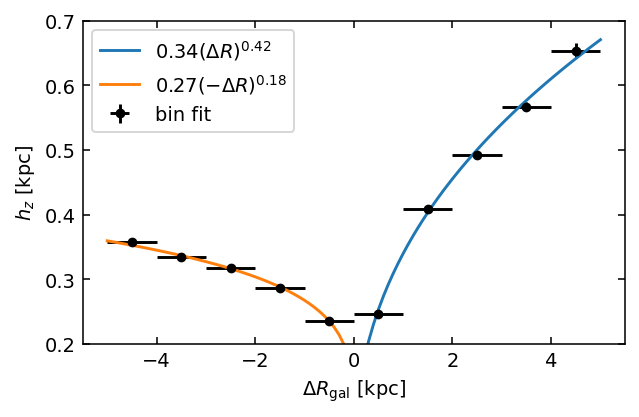

In [58]:
fig, ax = plt.subplots()
dr_plot_arr = np.arange(-5, 5.1, 0.1)
ax.errorbar(dr_arr, dr_params, xerr=0.5, yerr=dr_errors, label='bin fit',
            marker='o', markersize=4, linestyle='none', color='k')
# powerlaw fit - positive delta r
popt, pcov = curve_fit(powerlaw, dr_arr[dr_arr > 0], dr_params[dr_arr > 0],
                       sigma=dr_errors[dr_arr > 0])
ax.plot(dr_plot_arr[dr_plot_arr > 0], powerlaw(dr_plot_arr[r_plot_arr > 0], *popt), 
        label=r'$%.02f(\Delta R)^{%.02f}$' % tuple(popt))
# powerlaw fit - negative delta r
popt, pcov = curve_fit(powerlaw, -dr_arr[dr_arr < 0], dr_params[dr_arr < 0],
                       sigma=dr_errors[dr_arr < 0])
ax.plot(dr_plot_arr[dr_plot_arr < 0], powerlaw(-dr_plot_arr[r_plot_arr < 0], *popt), 
        label=r'$%.02f(-\Delta R)^{%.02f}$' % tuple(popt))

ax.set_xlabel(r'$\Delta R_{\rm{gal}}$ [kpc]')
ax.set_ylabel(r'$h_z$ [kpc]')
ax.set_ylim((0.2, 0.7))
ax.legend()
plt.show()

A power law provides a good fit to the change in vertical scale height $h_z$ with $\Delta R$, but with different fits for positive and negative $\Delta R$.

In [144]:
def scale_height_dr(dr):
    """
    The vertical scale height $h_z$ of the disk as a function of radial migration distance $\Delta R$.
    
    Parameters
    ----------
    dr : float
        Radial migration distance $\Delta R$ in kpc.
    
    Returns
    -------
    float
        Vertical scale height $h_z$.
    """
    if dr >= 0:
        return 0.34 * dr ** 0.42
    else:
        return 0.27 * (-dr) ** 0.18
    
def scale_height_dr_arr(dr):
    """
    Same as scale_height_dr() but takes an array as input.
    
    Parameters
    ----------
    dr : array-like
        Radial migration distance $\Delta R$ in kpc.
    
    Returns
    -------
    float
        Vertical scale height $h_z$.
    """
    hz = np.zeros(dr.shape)
    # positive dr
    hz[dr > 0] = 0.34 * dr[dr >= 0] ** 0.42
    # negative dr
    hz[dr < 0] = 0.27 * (-dr[dr < 0]) ** 0.18
    return hz

Checking the overall fit:

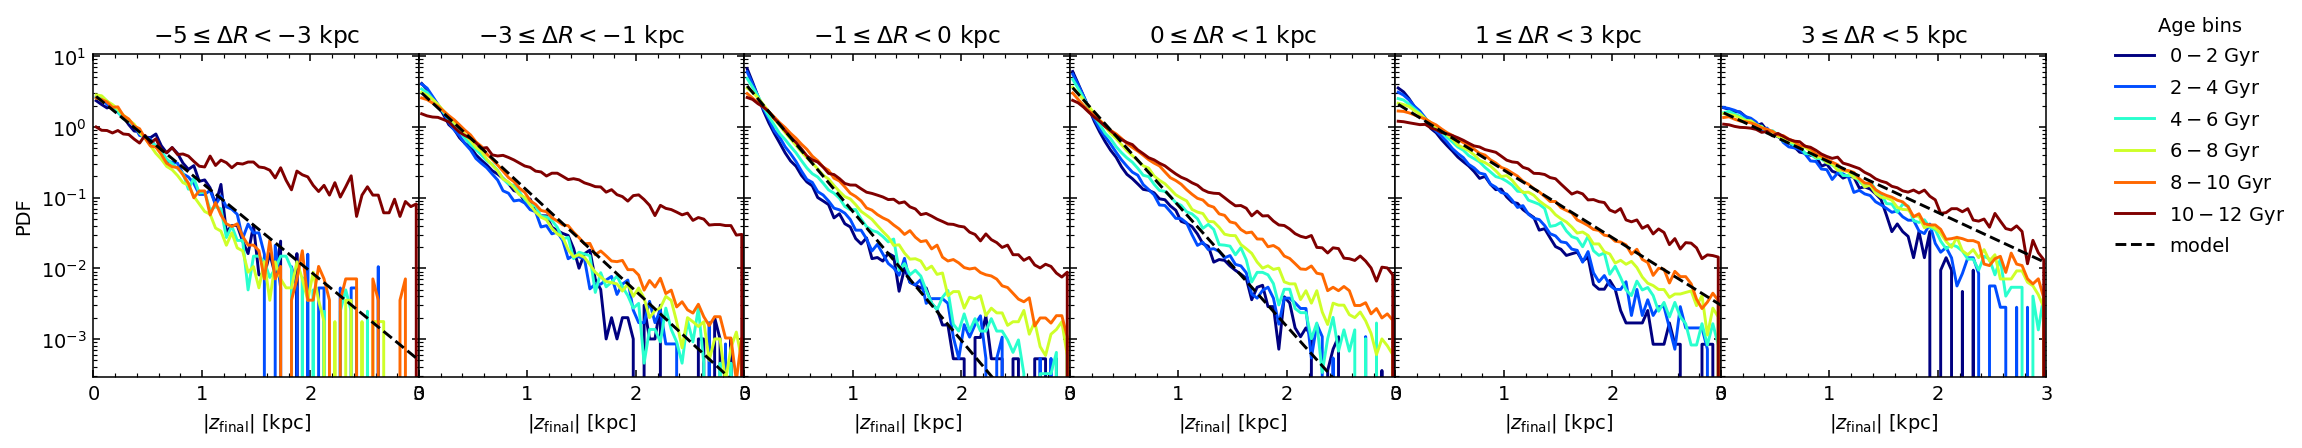

In [111]:
dr_bins = np.array([-5, -3, -1, 0, 1, 3, 5])
age_bins = np.arange(0, 14, 2, dtype='float')
absz_bins = np.arange(0, 5.05, 0.05)

fig, axs = plt.subplots(1, 6, figsize=(18, 3), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.)

for i, ax in enumerate(axs):
    dr_lim = tuple(dr_bins[i:i+2])
    ax.set_title(r'$%d\leq \Delta R < %d$ kpc' % dr_lim)
    ax.set_xlabel(r'$|z_{\rm{final}}|$ [kpc]')
    # plot distribution of |z| in bins of delta r and age
    for j, color in enumerate(colors):
        age_lim = tuple(age_bins[j:j+2])
        subset = data[(data['dr']  >= dr_lim[0]) &
                      (data['dr']  <  dr_lim[1]) &
                      (data['age'] >= age_lim[0]) &
                      (data['age'] <  age_lim[1])]
        if subset.shape[0] > 100:
            hist, _ = np.histogram(np.abs(subset['zfinal']), absz_bins, density=True)
            bin_centers = (absz_bins[:-1] + absz_bins[1:]) / 2
            if i == 0:
                label = r'$%d - %d$ Gyr' % age_lim
            else:
                label = None
            ax.plot(bin_centers, hist, c=color, ls='-', label=label)
    # plot exponential model distribution as a function of dr
    hz = scale_height_dr((dr_lim[0] + dr_lim[1])/2)
    if i == 0:
        label = 'model'
    else:
        label = None
    ax.plot(bin_centers, normal_exponential(bin_centers, hz), c='k', ls='--', label=label)

axs[0].set_ylabel('PDF')
axs[0].set_xlim((0, 3))
axs[0].set_yscale('log')
axs[0].xaxis.set_minor_locator(MultipleLocator(0.2))
fig.legend(title='Age bins', loc='upper right', frameon=False)
plt.show()

This first model captures the overall distributions well, but it does miss out on the additional small dependence on age in some bins. Even excluding the oldest age bin which has a radically different structure, the distributions do shift with age especially for stars with small $\Delta R$ (center panels). However, in my final analysis I only look at populations in three bins of $|z|$ between 0 and 2 kpc.

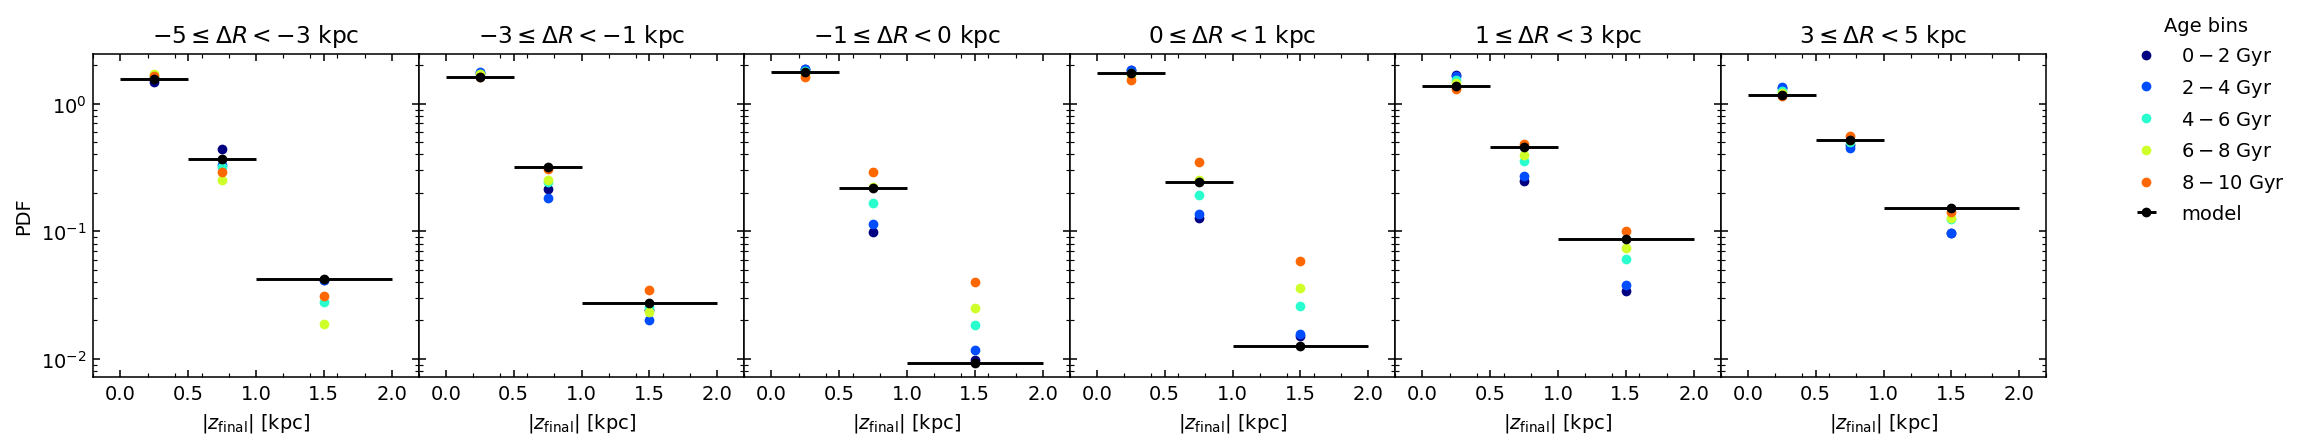

In [91]:
dr_bins = np.array([-5, -3, -1, 0, 1, 3, 5])
# exclude the oldest age bin
age_bins = np.arange(0, 12, 2, dtype='float')
absz_bins = np.array([0, 0.5, 1., 2.])

fig, axs = plt.subplots(1, 6, figsize=(18, 3), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.)

for i, ax in enumerate(axs):
    dr_lim = tuple(dr_bins[i:i+2])
    ax.set_title(r'$%d\leq \Delta R < %d$ kpc' % dr_lim)
    ax.set_xlabel(r'$|z_{\rm{final}}|$ [kpc]')
    # plot distribution of |z| in bins of delta r and age
    for j, color in enumerate(colors[:-1]):
        age_lim = tuple(age_bins[j:j+2])
        subset = data[(data['dr']  >= dr_lim[0]) &
                      (data['dr']  <  dr_lim[1]) &
                      (data['age'] >= age_lim[0]) &
                      (data['age'] <  age_lim[1])]
        if subset.shape[0] > 100:
            hist, _ = np.histogram(np.abs(subset['zfinal']), absz_bins, density=True)
            bin_centers = (absz_bins[:-1] + absz_bins[1:]) / 2
            if i == 0:
                label = r'$%d - %d$ Gyr' % age_lim
            else:
                label = None
            ax.plot(bin_centers, hist, c=color, marker='o', markersize=4, 
                    ls='none', label=label)
    # plot exponential model distribution as a function of dr
    hz = scale_height_dr((dr_lim[0] + dr_lim[1])/2)
    if i == 0:
        label = 'model'
    else:
        label = None
    bin_widths = absz_bins[1:] - absz_bins[:-1]
    model_points = normal_exponential(bin_centers, hz)
    model_points *= 1 / np.sum(model_points * bin_widths)
    ax.errorbar(bin_centers, model_points, xerr=bin_widths/2, 
                c='k', linestyle='none', marker='o', markersize=4, label=label)

axs[0].set_ylabel('PDF')
axs[0].set_xlim((-0.2, 2.2))
axs[0].set_yscale('log')
axs[0].xaxis.set_minor_locator(MultipleLocator(0.2))
fig.legend(title='Age bins', loc='upper right', frameon=False)
plt.show()

This model does tend to underestimate the density of stars far away from the midplane for older populations with small $\Delta R$. Then again, may be a small fraction of the total, as most old stars will have migrated a fair ways radially.

### Model 2: $R_\rm{form}$ and age

The $\Delta R$ dependence from the first model contains an implicit dependence on $R_\rm{form}$ and age. Rather than adding an age term to the first model, I create a second model just in terms of $R_\rm{form}$ and age. Once again, I center the bins for radial dependence on a 1 Gyr age, and the bins for age dependence on $R_\rm{form}=8$ kpc. I also exclude the inner 100 pc "core" which appears to diverge from the overall exponential shape.

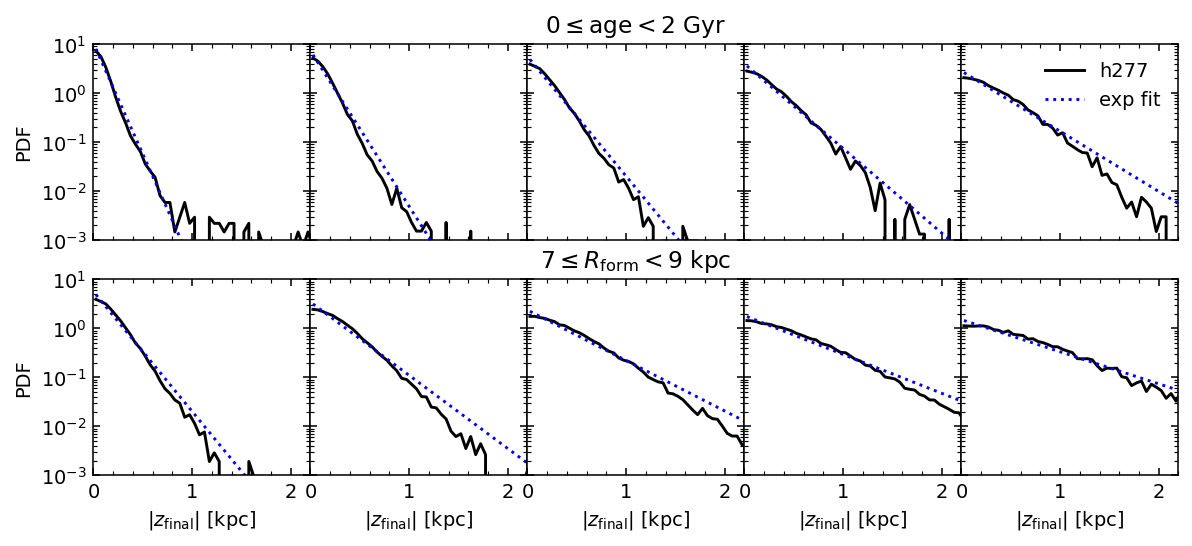

In [126]:
# Set up bins
age_bin_width = 2
age_bins = np.arange(0, 12, age_bin_width, dtype='float')
age_arr = (age_bins[:-1] + age_bins[1:]) / 2
rform_bin_width = 2
rform_bins = np.arange(3, 15, rform_bin_width, dtype='float')
rform_arr = (rform_bins[:-1] + rform_bins[1:]) / 2
absz_bins = np.arange(0., 5.05, 0.05)
# core width in kpc
core = 0.1

# plot demonstrating Gaussian fits
fig, axs = plt.subplots(2, 5, figsize=(10, 4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0., hspace=0.2)

# fixed age, varying rform
fixed_age_lim = (0, 2)
axs[0,2].set_title(r'$%d \leq \rm{age} < %d$ Gyr' % fixed_age_lim)
rform_params = np.zeros(rform_arr.shape)
rform_errors = np.zeros(rform_arr.shape)
for i in range(rform_bins.shape[0] - 1):
    rform_lim = tuple(rform_bins[i:i+2])
    subset = data[(data['rform'] >= rform_lim[0]) &
                  (data['rform'] <  rform_lim[1]) &
                  (data['age']   >= fixed_age_lim[0]) &
                  (data['age']   <  fixed_age_lim[1])]
    # h277 distribution
    hist, _ = np.histogram(subset['zfinal'].abs(), absz_bins, density=True)
    bin_centers = (absz_bins[:-1] + absz_bins[1:]) / 2
    axs[0,i].plot(bin_centers, hist, 'k-', label='h277')
    # model exponential
    popt, pcov = curve_fit(normal_exponential, 
                           bin_centers[bin_centers > core], 
                           hist[bin_centers > core])
    axs[0,i].plot(bin_centers, normal_exponential(bin_centers, *popt), 'b:',
                  label='exp fit')
    # save params
    rform_params[i] = popt[0]
    rform_errors[i] = np.sqrt(np.diag(pcov))[0]

# fixed rform, varying age
fixed_rform_lim = (7, 9)
axs[1,2].set_title(r'$%d \leq R_{\rm{form}} < %d$ kpc' % fixed_rform_lim)
age_params = np.zeros(age_arr.shape)
age_errors = np.zeros(age_arr.shape)
for i in range(age_bins.shape[0] - 1):
    age_lim = tuple(age_bins[i:i+2])
    subset = data[(data['rform'] >= fixed_rform_lim[0]) &
                  (data['rform'] <  fixed_rform_lim[1]) &
                  (data['age']   >= age_lim[0]) &
                  (data['age']   <  age_lim[1])]
    hist, _ = np.histogram(subset['zfinal'].abs(), absz_bins, density=True)
    bin_centers = (absz_bins[:-1] + absz_bins[1:]) / 2
    axs[1,i].plot(bin_centers, hist, 'k-', label='h277')
    # model gaussian
    popt, pcov = curve_fit(normal_exponential, 
                           bin_centers[bin_centers > core], 
                           hist[bin_centers > core])
    axs[1,i].plot(bin_centers, normal_exponential(bin_centers, *popt), 'b:',
                  label='exp fit')
    age_params[i] = popt[0]
    age_errors[i] = np.sqrt(np.diag(pcov))[0]

for ax in axs[1,:]:
    ax.set_xlabel(r'$|z_{\rm{final}}|$ [kpc]')
axs[0,0].set_xlim((0, 2.2))
axs[0,0].xaxis.set_minor_locator(MultipleLocator(0.2))
for ax in axs[:,0]:
    ax.set_ylabel('PDF')
axs[0,0].set_yscale('log')
axs[0,0].set_ylim((1e-3, 10))
axs[0,-1].legend(frameon=False)
plt.show()

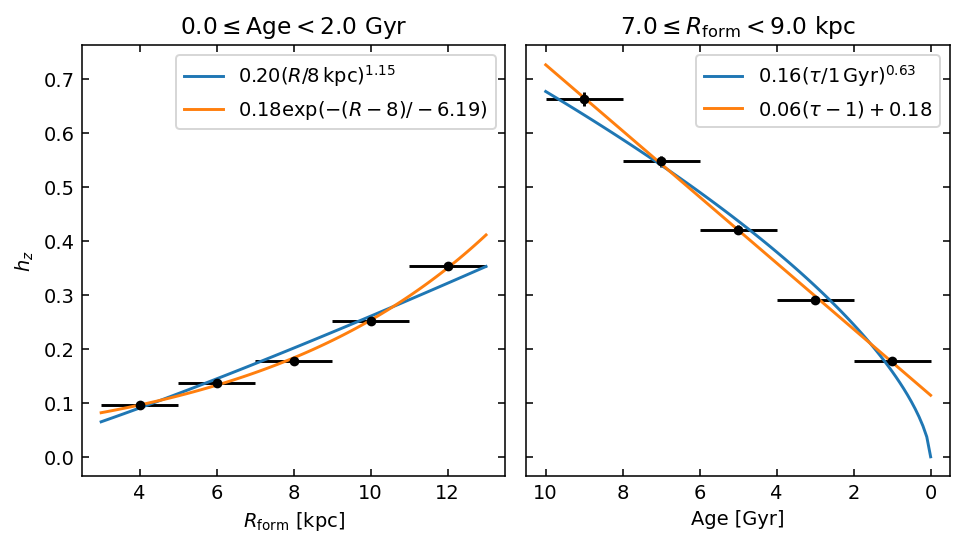

In [186]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
plt.subplots_adjust(wspace=0.05)

# fixed age, varying rform
axs[0].errorbar(rform_arr, rform_params, xerr=1, yerr=rform_errors, 
                linestyle='none', c='k', marker='o', markersize=4)
# plaw fit, scaled to 8 kpc
popt, pcov = curve_fit(powerlaw, rform_arr/8, rform_params, 
                       sigma=rform_errors)
rform_plot_arr = np.arange(3, 13.1, 0.1)
axs[0].plot(rform_plot_arr, powerlaw(rform_plot_arr/8, *popt), 
            label=r'$%.02f (R/8\,\rm{kpc})^{%.02f}$' % tuple(popt))
# exponential fit
popt, pcov = curve_fit(exponential, rform_arr-8, rform_params,
                       sigma=rform_errors, p0=(1, -1))
axs[0].plot(rform_plot_arr, exponential(rform_plot_arr-8, *popt),
            label=r'$%.02f \exp(-(R-8)/%.02f)$' % tuple(popt))
axs[0].set_xlabel(r'$R_{\rm{form}}$ [kpc]')
axs[0].set_ylabel(r'$h_z$')
axs[0].set_title(r'$%.1f \leq \rm{Age} < %.1f$ Gyr' % fixed_age_lim)
axs[0].legend()

# fixed rform, varying age
axs[1].errorbar(age_arr, age_params, xerr=1, yerr=age_errors, 
                linestyle='none', c='k', marker='o', markersize=4)
# Plot plaw fit
popt, pcov = curve_fit(powerlaw, age_arr, age_params, 
                       sigma=age_errors)
age_plot_arr = np.arange(0, 10.1, 0.1)
axs[1].plot(age_plot_arr, powerlaw(age_plot_arr, *popt), 
            label=r'$%.02f (\tau/1\,\rm{Gyr})^{%.02f}$' % tuple(popt))
linfit = np.polyfit(age_arr-1, age_params, 1, w=1/age_errors)
axs[1].plot(age_plot_arr, np.poly1d(linfit)(age_plot_arr-1), 
            label=r'$%.02f (\tau-1) + %.02f$' % tuple(linfit))
axs[1].set_xlabel('Age [Gyr]')
axs[1].invert_xaxis()
axs[1].xaxis.set_major_locator(MultipleLocator(2))
axs[1].set_title(r'$%.1f \leq R_{\rm{form}} < %.1f$ kpc' % fixed_rform_lim)
axs[1].legend()

plt.show()

So my equation for the dependence of $|z_{\rm{final}}|$ on age and formation radius is:

$$ h_z = 0.18 (R_\rm{form}/8\,\rm{kpc})^{1.15} (\tau/1\,\rm{Gyr})^{0.63} $$

In [194]:
def scale_height_age_rform(age, rform):
    r"""
    The scale height $h_z$ as a function of age and formation radius $R_{\rm{form}}$:
    
    $$ h_z = 0.18 (R_\rm{form}/8\,\rm{kpc})^{1.15} (\tau/1\,\rm{Gyr})^{0.63} $$
    
    Parameters
    ----------
    age : float or array-like
        Age in Gyr.
    rform : float or array-like
        Formation radius $R_{\rm{form}}$ in kpc.
    
    Returns
    -------
    float
        Scale height $h_z$ in kpc
    """
    return 0.18 * (age ** 0.63) * (rform / 8) ** 1.15
    # return (0.18 + 0.06 * (age - 1)) * np.exp((rform - 8) / 6.19)

Checking against the full distribution:

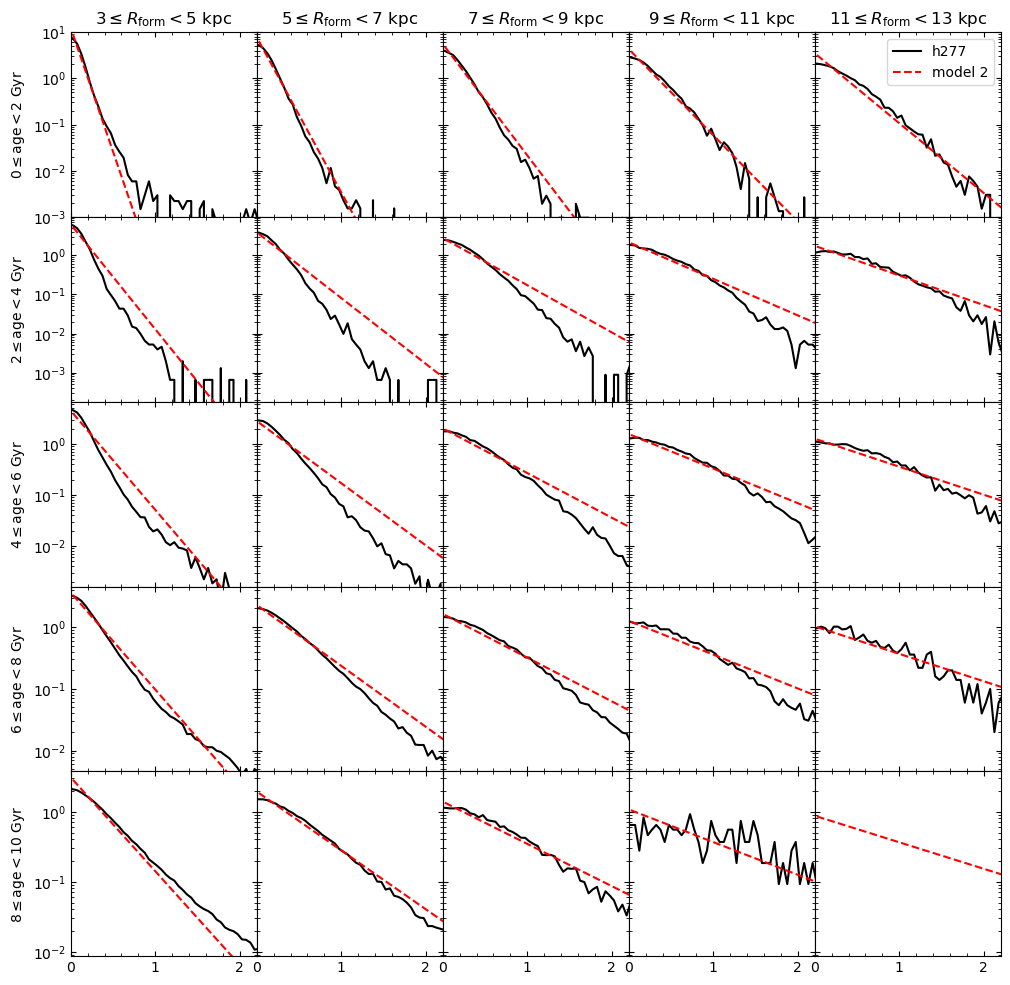

In [195]:
rform_bins = np.arange(3, 15, 2, dtype='float')
age_bins = np.arange(0, 12, 2, dtype='float')
# absz_bins = np.logspace(-1.5, 0.5, 100)
absz_bins = np.arange(0., 5.05, 0.05)

fig, axs = plt.subplots(5, 5, figsize=(12, 12), sharex=True, sharey='row', dpi=100)
plt.subplots_adjust(wspace=0., hspace=0.)

for i, row in enumerate(axs):
    age_lim = tuple(age_bins[i:i+2])
    for j, ax in enumerate(row):
        rform_lim = tuple(rform_bins[j:j+2])
        # h277 distribution
        subset = data[(data['rform'] >= rform_lim[0]) &
                      (data['rform'] <  rform_lim[1]) &
                      (data['age']   >= age_lim[0]) &
                      (data['age']   <  age_lim[1])]
        if subset.shape[0] > 100:
            hist, _ = np.histogram(subset['zfinal'].abs(), absz_bins, density=True)
            bin_centers = (absz_bins[:-1] + absz_bins[1:]) / 2
            ax.plot(bin_centers, hist, c='k', ls='-', label='h277')
        # model
        age = (age_lim[0] + age_lim[1]) / 2
        rform = (rform_lim[0] + rform_lim[1]) / 2
        hz = scale_height_age_rform(age, rform)
        ax.plot(bin_centers, exp(bin_centers, hz), 'r--', label='model 2')
        if i == 0:
            ax.set_title(r'$%d\leq R_{\rm{form}} < %d$ kpc' % rform_lim)
        if j == 0:
            ax.set_ylabel(r'$%d\leq \rm{age} < %d$ Gyr' % age_lim)
        ax.set_yscale('log')

axs[0,0].set_xlim((0, 2.2))
axs[0,0].xaxis.set_minor_locator(MultipleLocator(0.2))
axs[0,0].set_ylim((1e-3, 10))
# axs[0,0].set_xscale('log')
# axs[0,0].set_xlim((0.03, 3))
# for ax in axs[:,0]:
#     ax.set_yscale('log')
# fig.legend()
axs[0,-1].legend()
plt.show()

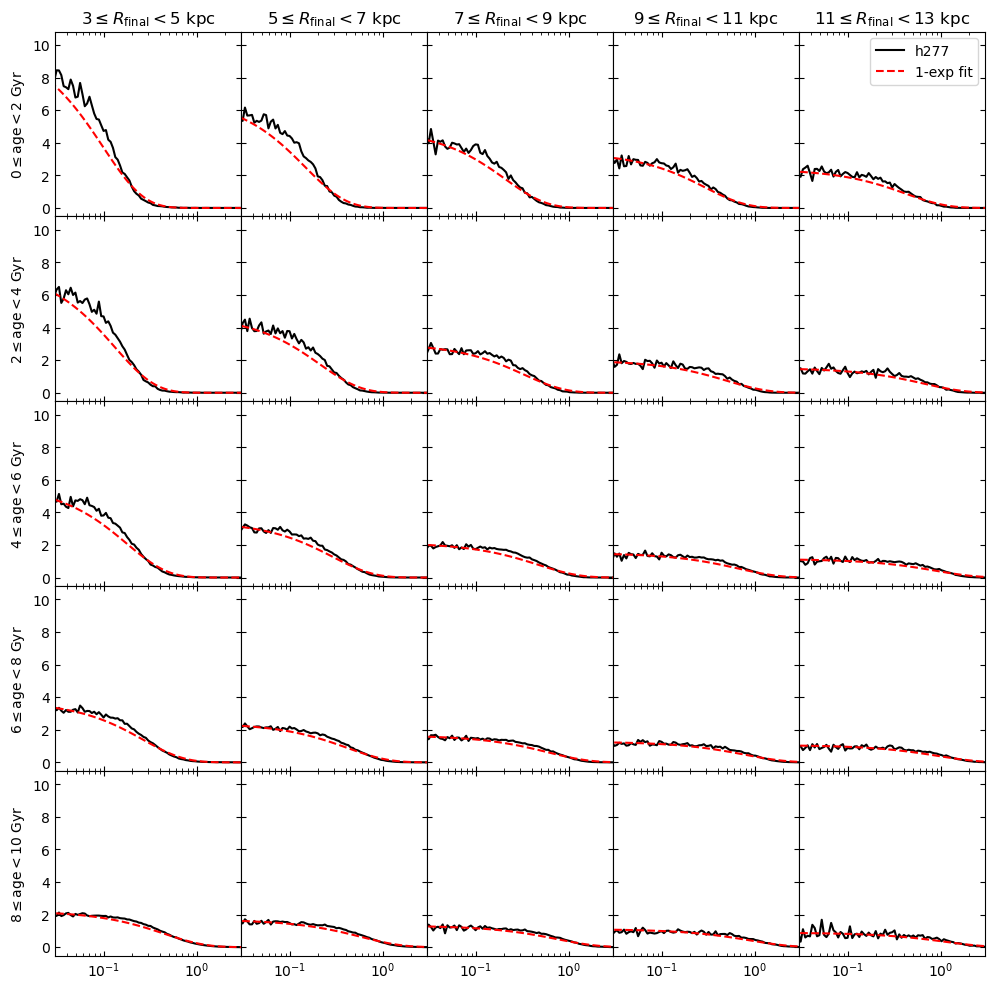

In [196]:
rfinal_bins = np.arange(3, 15, 2, dtype='float')
age_bins = np.arange(0, 12, 2, dtype='float')
absz_bins = np.logspace(-2, 0.5, 100)
# absz_bins = np.arange(0., 3.01, 0.01)

fig, axs = plt.subplots(5, 5, figsize=(12, 12), sharex=True, sharey=True, dpi=100)
plt.subplots_adjust(wspace=0., hspace=0.)

for i, row in enumerate(axs):
    age_lim = tuple(age_bins[i:i+2])
    for j, ax in enumerate(row):
        rfinal_lim = tuple(rfinal_bins[j:j+2])
        # h277 distribution
        subset = data[(data['rfinal'] >= rfinal_lim[0]) &
                      (data['rfinal'] <  rfinal_lim[1]) &
                      (data['age']   >= age_lim[0]) &
                      (data['age']   <  age_lim[1])]
        if subset.shape[0] > 500:
            hist, _ = np.histogram(subset['zfinal'].abs(), absz_bins, density=True)
            # hist_smooth = box_smooth(hist, absz_bins, 0.01)
            bin_centers = (absz_bins[:-1] + absz_bins[1:]) / 2
            ax.plot(bin_centers, hist, c='k', ls='-', label='h277')
            # model exponential
            popt, pcov = curve_fit(exp, bin_centers, hist)
            ax.plot(bin_centers, exp(bin_centers, *popt), 'r--', label='1-exp fit')
        if i == 0:
            ax.set_title(r'$%d\leq R_{\rm{final}} < %d$ kpc' % rfinal_lim)
        if j == 0:
            ax.set_ylabel(r'$%d\leq \rm{age} < %d$ Gyr' % age_lim)

axs[0,0].set_xscale('log')
axs[0,0].set_xlim((0.03, 3))
# axs[0,0].set_yscale('log')
# fig.legend()
axs[0,-1].legend()
plt.show()

NameError: name 'plaw' is not defined

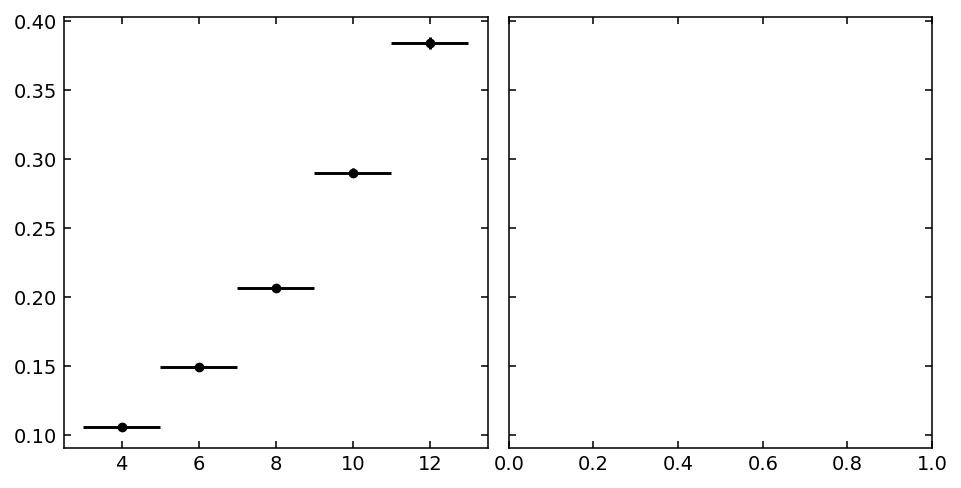

In [197]:
rfinal_bins = np.arange(3, 15, 2, dtype='float')
age_bins = np.arange(0, 12, 2, dtype='float')
absz_bins = np.arange(0., 3.01, 0.01)

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
plt.subplots_adjust(wspace=0.05)

# fixed age, varying rfinal
params = []
errors = []
age_lim = (0, 2)
for j in range(rfinal_bins.shape[0] - 1):
    rfinal_lim = tuple(rfinal_bins[j:j+2])
    subset = data[(data['rfinal']  >= rfinal_lim[0]) &
                  (data['rfinal']  <  rfinal_lim[1]) &
                  (data['age'] >= age_lim[0]) &
                  (data['age'] <  age_lim[1])]
    hist, _ = np.histogram(subset['zfinal'].abs(), absz_bins, density=True)
    bin_centers = (absz_bins[:-1] + absz_bins[1:]) / 2
    # model exponential
    popt, pcov = curve_fit(exp, bin_centers, hist)
    params.append(popt[0])
    errors.append(np.sqrt(np.diag(pcov))[0])
params = np.array(params)
errors = np.array(errors)

rfinal_arr = (rfinal_bins[:-1] + rfinal_bins[1:]) / 2
rfinal_plot_arr = np.arange(3, 13.1, 0.1)
axs[0].errorbar(rfinal_arr, params, xerr=1, yerr=errors, label='bin fit',
                linestyle='none', c='k', marker='o', markersize=4)
# powerlaw fit
popt, pcov = curve_fit(plaw, rfinal_arr/8, params, sigma=errors)
axs[0].plot(rfinal_plot_arr, plaw(rfinal_plot_arr/8, *popt), 
        label=r'$%.02f(R / 8\,\rm{kpc})^{%.02f}$' % tuple(popt))
axs[0].set_xlabel(r'$R_{\rm{final}}$ [kpc]')
axs[0].set_ylabel(r'$h_z$ [kpc]')
axs[0].set_title(r'$%.1f \leq \rm{Age} < %.1f$ Gyr' % age_lim)
axs[0].legend()

# fixed rfinal, varying age
params = []
errors = []
rfinal_lim = (7, 9)
for i in range(age_bins.shape[0] - 1):
    age_lim = tuple(age_bins[i:i+2])
    subset = data[(data['rfinal']  >= rfinal_lim[0]) &
                  (data['rfinal']  <  rfinal_lim[1]) &
                  (data['age'] >= age_lim[0]) &
                  (data['age'] <  age_lim[1])]
    hist, _ = np.histogram(subset['zfinal'].abs(), absz_bins, density=True)
    bin_centers = (absz_bins[:-1] + absz_bins[1:]) / 2
    # model exponential
    popt, pcov = curve_fit(exp, bin_centers, hist)
    params.append(popt[0])
    errors.append(np.sqrt(np.diag(pcov))[0])
params = np.array(params)
errors = np.array(errors)

age_arr = (age_bins[:-1] + age_bins[1:]) / 2
age_plot_arr = np.arange(0, 10.1, 0.1)
axs[1].errorbar(age_arr, params, xerr=1, yerr=errors, label='bin fit',
                linestyle='none', c='k', marker='o', markersize=4)
# Plot plaw fit
popt, pcov = curve_fit(plaw, age_arr, params, sigma=errors)
axs[1].plot(age_plot_arr, plaw(age_plot_arr, *popt),
            label=r'$%.02f (\tau / 1\,\rm{Gyr})^{%.02f}$' % tuple(popt))
axs[1].set_xlabel('Age [Gyr]')
axs[1].invert_xaxis()
axs[1].xaxis.set_major_locator(MultipleLocator(2))
axs[1].set_title(r'$%.1f \leq R_{\rm{final}} < %.1f$ kpc' % rfinal_lim)
axs[1].legend()

plt.show()

These parameters are very similar to those in Model 3.

## Checking Gaussian vs analog migration

In [198]:
rng = np.random.default_rng()
data['dr_sample'] = rng.normal(loc=0, 
                               scale=migr_scale(data['age'], data['rform']), 
                               size=data.shape[0])
data['rfinal_sample'] = data['rform'] + data['dr_sample']
data['zfinal_sample_1'] = rng.exponential(scale=scale_height_dr_arr(data['dr_sample']),
                                          size=data.shape[0])
data['zfinal_sample_2'] = rng.exponential(scale=scale_height_age_rform(data['age'], data['rform']),
                                          size=data.shape[0])

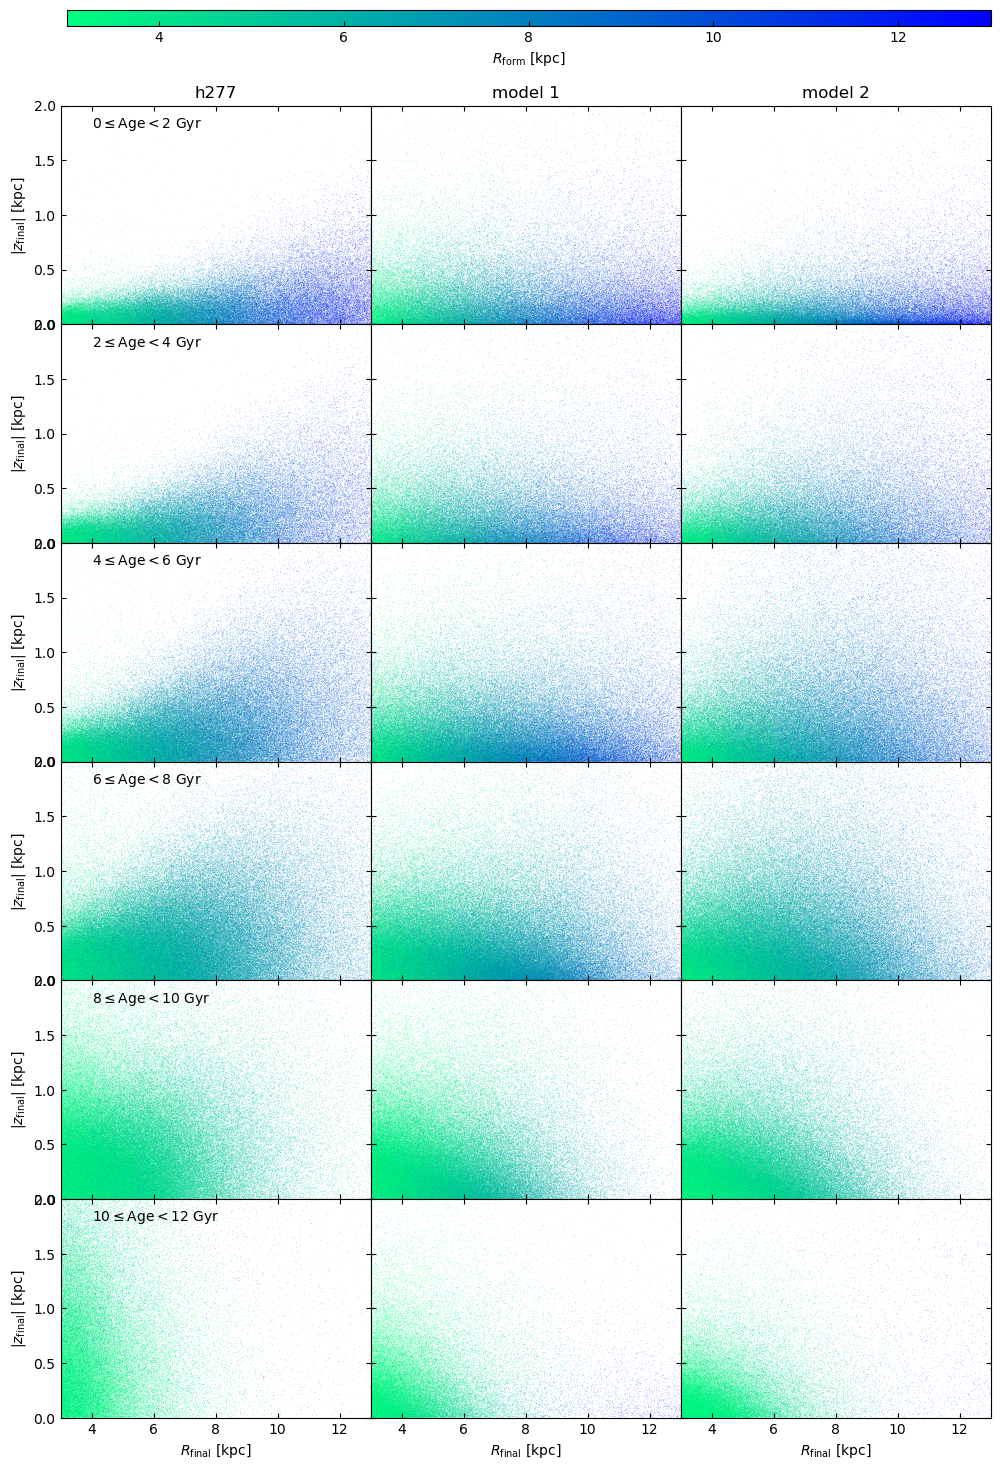

In [199]:
age_bins = np.arange(0, 14, 2, dtype='float')
fig, axs = plt.subplots(age_bins.shape[0] - 1, 3, figsize=(12, 16), sharex=True, sharey=True, dpi=100)
plt.subplots_adjust(hspace=0., wspace=0., top=0.93)
cax = plt.axes([0.13, 0.98, 0.77, 0.01])
norm = Normalize(vmin=3, vmax=13)
cmap = 'winter_r'
cbar = fig.colorbar(ScalarMappable(norm, cmap), cax, 
                    label=r'$R_{\rm{form}}$ [kpc]', orientation='horizontal')
axs[0,0].set_title('h277')
axs[0,1].set_title('model 1')
axs[0,2].set_title('model 2')
for i, row in enumerate(axs):
    age_lim = tuple(age_bins[i:i+2])
    axs[i,0].text(0.1, 0.9, r'$%d \leq \rm{Age} < %d$ Gyr' % age_lim, 
                  transform=axs[i,0].transAxes)
    # plot h277 data
    subset = data[(data['age'] >= age_lim[0]) &
                  (data['age'] <  age_lim[1])]
    axs[i,0].scatter(subset['rfinal'], subset['zfinal'].abs(), 
                     c=subset['rform'], cmap=cmap, norm=norm,
                     rasterized=True, s=0.1, edgecolor='none')
    # sample dr & zfinal (model 1)
    axs[i,1].scatter(subset['rfinal_sample'], subset['zfinal_sample_1'],
                     c=subset['rform'], cmap=cmap, norm=norm,
                     rasterized=True, s=0.1, edgecolor='none')
    # sample zfinal (model 2)
    axs[i,2].scatter(subset['rfinal_sample'], subset['zfinal_sample_2'],
                     c=subset['rform'], cmap=cmap, norm=norm,
                     rasterized=True, s=0.1, edgecolor='none')
axs[0,0].set_xlim((3, 13))
axs[0,0].set_ylim((0, 2))
for ax in axs[-1,:]:
    ax.set_xlabel(r'$R_{\rm{final}}$ [kpc]')
for ax in axs[:,0]:
    ax.set_ylabel(r'$|z_{\rm{final}}|$ [kpc]')
plt.show()

Same as above but with 2D histograms:

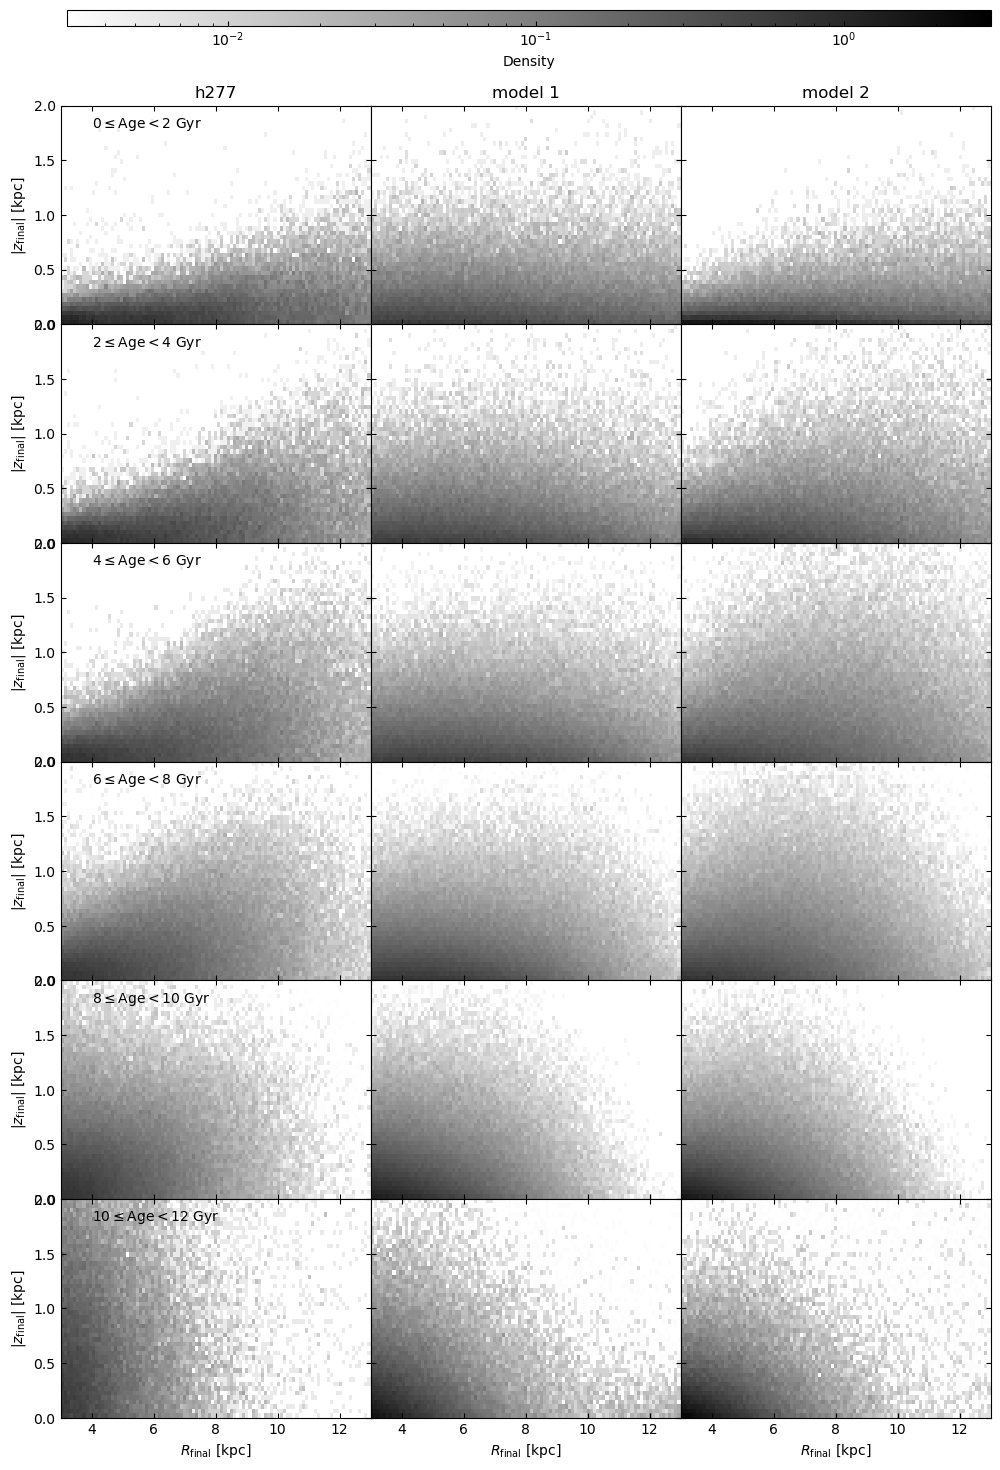

In [200]:
age_bins = np.arange(0, 14, 2, dtype='float')
rfinal_bins = np.linspace(3, 13, 100)
absz_bins = np.linspace(0, 2, 50)
fig, axs = plt.subplots(age_bins.shape[0] - 1, 3, figsize=(12, 16), sharex=True, sharey=True, dpi=100)
plt.subplots_adjust(hspace=0., wspace=0., top=0.93)
cax = plt.axes([0.13, 0.98, 0.77, 0.01])
norm = LogNorm(vmin=3e-3, vmax=3)
cmap = 'binary'
cbar = fig.colorbar(ScalarMappable(norm, cmap), cax, 
                    label='Density', orientation='horizontal')
axs[0,0].set_title('h277')
axs[0,1].set_title('model 1')
axs[0,2].set_title('model 2')
for i, row in enumerate(axs):
    age_lim = tuple(age_bins[i:i+2])
    axs[i,0].text(0.1, 0.9, r'$%d \leq \rm{Age} < %d$ Gyr' % age_lim, 
                  transform=axs[i,0].transAxes)
    # plot h277 data
    subset = data[(data['age'] >= age_lim[0]) &
                  (data['age'] <  age_lim[1])]
    axs[i,0].hist2d(subset['rfinal'], subset['zfinal'], bins=[rfinal_bins, absz_bins],
                    density=True, cmap=cmap, norm=norm)
    # sample dr & zfinal (model 1)
    axs[i,1].hist2d(subset['rfinal_sample'], subset['zfinal_sample_1'],
                    bins=[rfinal_bins, absz_bins], density=True,
                    cmap=cmap, norm=norm)
    # sample zfinal (model 2)
    axs[i,2].hist2d(subset['rfinal_sample'], subset['zfinal_sample_2'],
                    bins=[rfinal_bins, absz_bins], density=True,
                    cmap=cmap, norm=norm)
axs[0,0].set_xlim((3, 13))
axs[0,0].set_ylim((0, 2))
for ax in axs[-1,:]:
    ax.set_xlabel(r'$R_{\rm{final}}$ [kpc]')
for ax in axs[:,0]:
    ax.set_ylabel(r'$|z_{\rm{final}}|$ [kpc]')
plt.show()